In [1]:
%pylab inline
import pandas as pd
import time
import re
import itertools
from scipy.special import logsumexp
from sklearn.datasets import load_svmlight_file, make_blobs, fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import nltk

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

        
class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    """
    
    def __init__(self, l2_coef=0.001):
        """
        Задание параметров оракула.
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.lambda_2 = l2_coef
     
    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        return (1 / X.shape[0]) * (np.logaddexp(0, (-1) * y * X.dot(w)).sum(axis=0))\
            + (self.lambda_2 / 2) * (w ** 2).sum()
        
    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        s1 = scipy.special.expit((-y) * X.dot(w)) * (-y)
        return (1 / X.shape[0]) * X.T.dot(s1) + self.lambda_2 * w
    
    
class MulticlassLogistic(BaseSmoothOracle):
    """
    Оракул для задачи многоклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    
    w в этом случае двумерный numpy array размера (class_number, d),
    где class_number - количество классов в задаче, d - размерность задачи
    """
    
    def __init__(self, class_number=None, l2_coef=0.001):
        """
        Задание параметров оракула.
        
        class_number - количество классов в задаче
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.lambda_2 = l2_coef
        self.class_number = class_number
     
    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        if self.class_number == None:
            self.class_number = max(y) + 1
        A = X.dot(w.T)
        return (self.lambda_2 / 2) * (np.linalg.norm(w) ** 2) + (1 / X.shape[0]) * (logsumexp(A, axis=1).sum()) +\
               (-1 / X.shape[0]) * (A[y.reshape(len(y), 1) == np.arange(self.class_number)]).sum()
        
    def grad(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        if self.class_number == None:
            self.class_number = max(y) + 1
        s1 = X.T.dot((y.reshape(len(y), 1) == np.arange(self.class_number)))
        s2 = X.T.dot((1 / np.exp(X.dot(w.T) - np.amax(X.dot(w.T), axis=1).reshape(X.shape[0], 1)).sum(axis=1)).reshape(X.shape[0], 1)
              * np.exp(X.dot(w.T) - np.amax(X.dot(w.T), axis=1).reshape(X.shape[0], 1)))
        return (-1 / X.shape[0]) * s1.T + (1 / X.shape[0]) * s2.T + self.lambda_2 * w
    

In [3]:
import numpy as np
import time


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        - 'multinomial_logistic' - многоклассовая логистическая регрессия
                
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если (f(x_{k+1}) - f(x_{k})) < tolerance: то выход 
        
        max_iter - максимальное число итераций     
        
        **kwargs - аргументы, необходимые для инициализации   
        """
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs
        self.history = {}
        self.w = None
 
    def fit(self, X, y, w_0=None, trace=False, accuracy=False):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w_0 - начальное приближение в методе
        
        trace - переменная типа bool
      
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        if self.loss_function == 'binary_logistic':
            self.cl = BinaryLogistic(**self.kwargs)
        else:
            self.cl = MulticlassLogistic(**self.kwargs)  
        if w_0 is None:
            if self.loss_function == 'binary_logistic':
                self.w = np.zeros(X.shape[1])
            else:
                self.w = np.zeros((self.cl.class_number, X.shape[1]))
        else:
            self.w = w_0
        if accuracy is True:
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=11)
            self.history['accuracy'] = [(self.predict(X_test) == y_test).sum() / y_test.shape[0]]
        else:
            X_train, y_train = X, y
        if trace is True:
            self.history['time'] = [0]
            self.history['func'] = [self.get_objective(X_train, y_train)]
        for i in range(self.max_iter):
            start = time.time()
            prev_f = self.get_objective(X_train, y_train)
            self.w = self.w - (self.step_alpha/((i + 1) ** (self.step_beta))) * self.get_gradient(X_train, y_train)
            if accuracy is True:
                self.history['accuracy'].append((self.predict(X_test) == y_test).sum() / y_test.shape[0])
            if trace is True:
                self.history['func'].append(self.get_objective(X_train, y_train))
                self.history['time'].append(time.time() - start + self.history['time'][-1])
            if abs(prev_f - self.get_objective(X, y)) < self.tolerance:
                break
        return self.history if (trace is True) else None
    
    def predict(self, X, threshold=0.5):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        if self.loss_function == 'binary_logistic':
            return np.where(self.predict_proba(X)[:, 1] > threshold, 1, -1)
        else:
            return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k 
        """
        if self.loss_function == 'binary_logistic':
            proba = scipy.special.expit(X.dot(self.w))
            return np.vstack((1 - proba, proba)).T
        else:
            return (1 / np.exp(X.dot(self.w.T) - np.amax(X.dot(self.w.T), axis=1).reshape(X.shape[0], 1)).sum(axis=1)).reshape(X.shape[0], 1)\
                    * np.exp(X.dot(self.w.T) - np.amax(X.dot(self.w.T), axis=1).reshape(X.shape[0], 1))
            
        
    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        return self.cl.func(X, y, self.w)
        
    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        return self.cl.grad(X, y, self.w)
    
    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.w
        

class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, batch_size=1, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        - 'multinomial_logistic' - многоклассовая логистическая регрессия
        
        batch_size - размер подвыборки, по которой считается градиент
        
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если (f(x_{k+1}) - f(x_{k})) < tolerance: то выход 
        
        
        max_iter - максимальное число итераций
        
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        
        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs
        self.history = {}
        self.random_seed = random_seed
        self.w = None
        
    def fit(self, X, y, w_0=None, trace=False, log_freq=1, accuracy=False):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
                
        w_0 - начальное приближение в методе
        
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет 
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления. 
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.random_seed)
        if self.loss_function == 'binary_logistic':
            self.cl = BinaryLogistic(**self.kwargs)
        else:
            self.cl = MulticlassLogistic(**self.kwargs)  
        if w_0 is None:
            if self.loss_function == 'binary_logistic':
                self.w = np.zeros(X.shape[1])
            else:
                self.w = np.zeros((self.cl.class_number, X.shape[1]))
        else:
            self.w = w_0
        if accuracy is True:
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=11)
            self.history['accuracy'] = [(self.predict(X_test) == y_test).sum() / y_test.shape[0]]
        else:
            X_train, y_train = X, y
        self.history['func'] = [self.get_objective(X_train, y_train)]
        self.history['epoch'] = [0]
        if trace is True:
            self.history['time'] = [0]
            self.history['weights_diff'] = [0]
        curr_ep = 0
        coefs = np.random.choice(range(X_train.shape[0]), self.max_iter * self.batch_size)
        
        for i in range(self.max_iter):
            start = time.time()
            prev_w = self.w
            self.w = self.w - (self.step_alpha/((i + 1) ** (self.step_beta))) *\
                               self.get_gradient(X_train[coefs[i * self.batch_size:(i + 1) * self.batch_size:]],\
                                                 y_train[coefs[i * self.batch_size:(i + 1) * self.batch_size:]])
            curr_ep = self.batch_size * (i + 1) / X.shape[0]
            if (curr_ep - self.history['epoch'][-1] >= log_freq):
                self.history['func'].append(self.get_objective(X_train, y_train))
                self.history['epoch'].append(curr_ep)
                if accuracy is True:
                    self.history['accuracy'].append((self.predict(X_test) == y_test).sum() / y_test.shape[0])
                if trace is True:
                    self.history['time'].append(time.time() - start + self.history['time'][-1])
                    self.history['weights_diff'].append(((prev_w - self.w) ** 2).sum())
                if abs(self.history['func'][-2] - self.history['func'][-1]) < self.tolerance:
                    break
        return self.history if (trace is True) else None


In [4]:
class MulticlassStrategy:   
    def __init__(self, classifier, mode, **kwargs):
        """
        Инициализация мультиклассового классификатора
        
        classifier - базовый бинарный классификатор
        
        mode - способ решения многоклассовой задачи,
        либо 'one_vs_all', либо 'all_vs_all'
        
        **kwargs - параметры классификатор
        """
        self.kwargs = kwargs
        self.classifier = classifier
        self.mode = mode
        
        
    def fit(self, X, y):
        """
        Обучение классификатора
        """
        self.classifier_set = []
        if self.mode == 'one_vs_all':
            for i in range(0, np.max(y) + 1):
                mask = y != i
                temp = y.copy()
                temp[mask] = -1
                temp_classifier = self.classifier(**self.kwargs)
                temp_classifier.fit(X, temp)
                self.classifier_set.append(temp_classifier)
        else:
            self.max = np.max(y)
            for i in range(self.max):
                l = []
                for j in range(i + 1, self.max + 1):
                    mask1 = y == i
                    mask2 = y == j
                    temp = y.copy()
                    temp[mask1] = 1
                    temp[mask2] = -1
                    l.append(self.classifier(**self.kwargs))
                    l[-1].fit(X[mask1 | mask2], temp[mask1 | mask2])
                self.classifier_set.append(l)
    
    def predict(self, X):
        """
        Выдача предсказаний классификатором
        """
        if self.mode == 'one_vs_all':
            y = [cl.predict_proba(X)[:, 1] for cl in self.classifier_set]
            return np.array(y).argmax(axis = 0)
        else:
            max_count = np.zeros((X.shape[0], 1)).astype(int)
            arr = np.empty((X.shape[0], 0))
            for i in range(self.max):
                for j in range(i, self.max):
                    pred = np.where(self.classifier_set[i][j - i].predict_proba(X)[:, 1] > 0.5, i, j + 1)
                    arr = np.hstack((arr, pred[:, np.newaxis]))
            res = np.zeros((X.shape[0], 1)).astype(int)
            max_count = np.zeros((X.shape[0], 1)).astype(int)
            for i in range(self.max + 1):
                temp = (arr == i).sum(axis=1).reshape((X.shape[0], 1))
                res[max_count < temp] = i
                max_count = np.maximum(max_count, temp)
            return res

In [5]:
def grad_finite_diff(function, w, eps=1e-8):
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """
    def additional_f(w, eps_v):
        return (function(w + eps_v) - function(w)) / eps
    return np.array(list(map(additional_f, np.tile(w, w.shape[0]).reshape(w.shape[0], w.shape[0]),
                             np.identity(w.shape[0]) * eps)))

# Эксперименты  
## Эксперимент №1

In [515]:
data = load_svmlight_file('real-sim.bz2')

In [516]:
X = data[0]
y = data[1]
X = (sparse.hstack((np.ones((data[0].shape[0], 1)), data[0]))).tocsr()

In [527]:
cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-7, step_alpha=1, step_beta=0, batch_size=1, random_seed=8538)
history = cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.138227818335 0.138227818335 0.138227818335


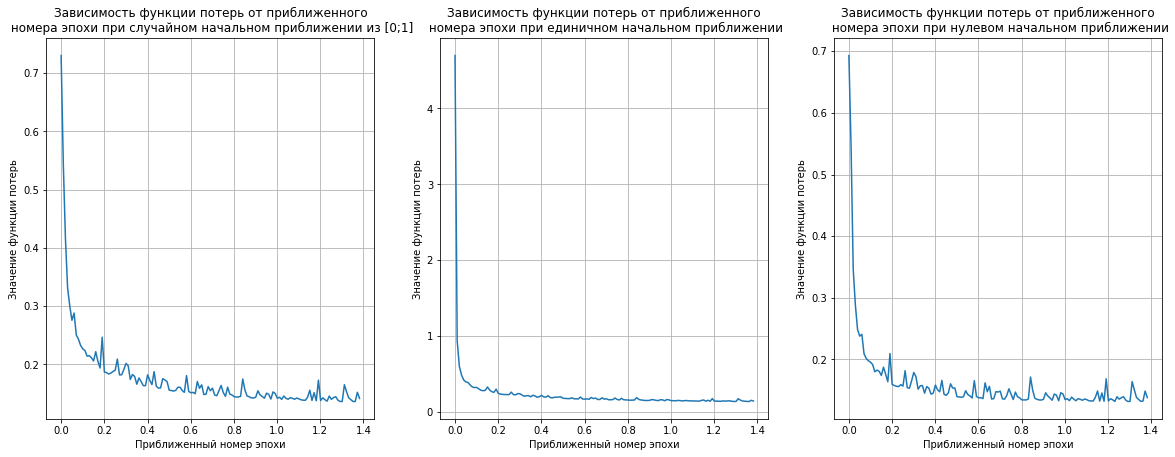

In [521]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

history_1 = cl.fit(X, y, log_freq=0.01, w_0=np.random.uniform(-1, 1, X.shape[1]), trace=True, accuracy=True)
ax1.plot(history_1['epoch'], history_1['func'])
ax1.set_title(u"Зависимость функции потерь от приближенного\n номера эпохи при случайном начальном приближении из [0;1]")
ax1.set_xlabel(u"Приближенный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()

history_2 = cl.fit(X, y, log_freq=0.01, w_0=np.ones(X.shape[1]), trace=True, accuracy=True)
ax2.plot(history_2['epoch'], history_2['func'])
ax2.set_title(u"Зависимость функции потерь от приближенного\n номера эпохи при единичном начальном приближении")
ax2.set_xlabel(u"Приближенный номер эпохи")
ax2.set_ylabel(u"Значение функции потерь")
ax2.grid()
ax2.legend()

history_3 = cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
ax3.plot(history_3['epoch'], history_3['func'])
ax3.set_title(u"Зависимость функции потерь от приближенного\n номера эпохи при нулевом начальном приближении")
ax3.set_xlabel(u"Приближенный номер эпохи")
ax3.set_ylabel(u"Значение функции потерь")
ax3.grid()
ax3.legend()

print(history_1['func'][-1], history_2['func'][-1], history_3['func'][-1])
plt.savefig("w0.pdf", format='pdf', bbox_inches='tight')

In [379]:
%time cl.fit(X, y, log_freq=1, trace=True, accuracy=True)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CPU times: user 41 s, sys: 626 ms, total: 41.6 s
Wall time: 41.8 s


{'accuracy': [0.68920850043792925, 0.95551560411192549],
 'epoch': [0, 1.0],
 'func': [0.69314718055994518, 0.14701098705325688],
 'time': [0, 0.007274150848388672],
 'weights_diff': [0, 3.1497624907119547e-05]}

In [529]:
cl_fgd = GDClassifier(max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-8, step_alpha=1, step_beta=0)
history_fgd = cl_fgd.fit(X, y, trace=True, accuracy=True)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


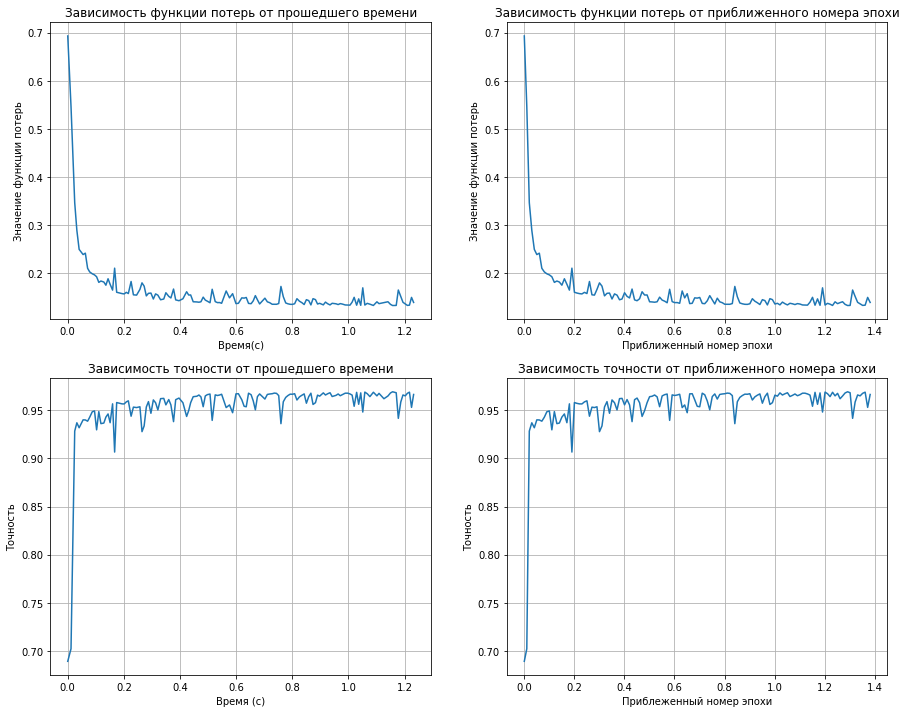

In [528]:
f, ax = plt.subplots(2, 2, figsize=(15,12))

ax[0, 0].plot(history['time'], history['func'])
ax[0, 0].set_title(u"Зависимость функции потерь от прошедшего времени")
ax[0, 0].set_xlabel(u"Время(с)")
ax[0, 0].set_ylabel(u"Значение функции потерь")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].plot(history['epoch'], history['func'])
ax[0, 1].set_title(u"Зависимость функции потерь от приближенного номера эпохи")
ax[0, 1].set_xlabel(u"Приближенный номер эпохи")
ax[0, 1].set_ylabel(u"Значение функции потерь")
ax[0, 1].grid()
ax[0, 1].legend()

ax[1, 0].plot(history['time'], history['accuracy'])
ax[1, 0].set_title(u"Зависимость точности от прошедшего времени")
ax[1, 0].set_xlabel(u"Время (с)")
ax[1, 0].set_ylabel(u"Точность")
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].plot(history['epoch'], history['accuracy'])
ax[1, 1].set_title(u"Зависимость точности от приближенного номера эпохи")
ax[1, 1].set_xlabel(u"Приблеженный номер эпохи")
ax[1, 1].set_ylabel(u"Точность")
ax[1, 1].grid()
ax[1, 1].legend()

plt.savefig("sgd.pdf", format='pdf', bbox_inches='tight')

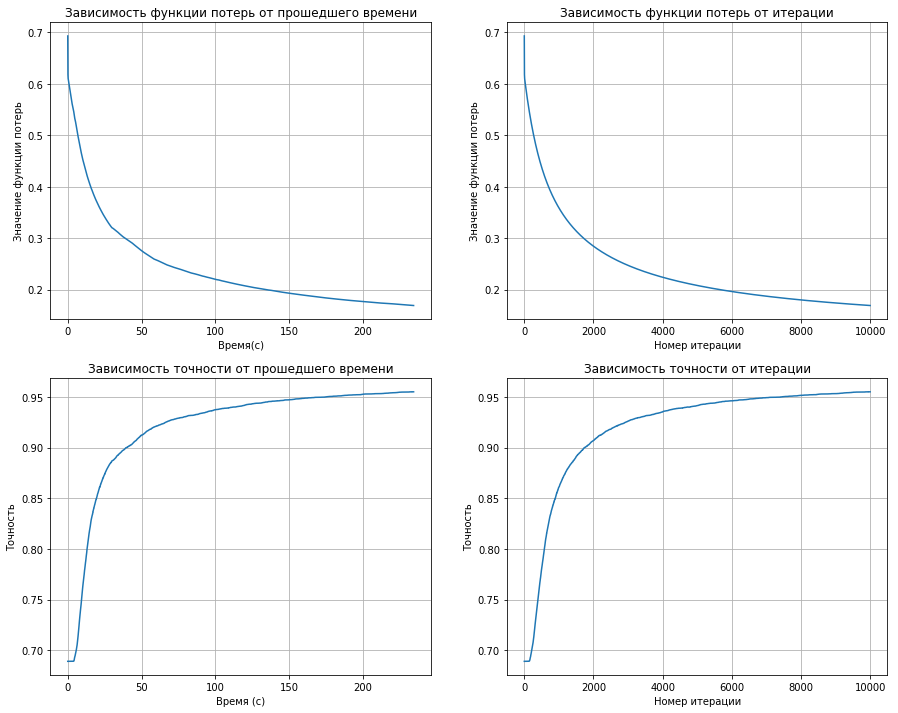

In [530]:
f, ax = plt.subplots(2, 2, figsize=(15,12))

ax[0, 0].plot(history_fgd['time'], history_fgd['func'])
ax[0, 0].set_title(u"Зависимость функции потерь от прошедшего времени")
ax[0, 0].set_xlabel(u"Время(с)")
ax[0, 0].set_ylabel(u"Значение функции потерь")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].plot(range(len(history_fgd['func'])), history_fgd['func'])
ax[0, 1].set_title(u"Зависимость функции потерь от итерации")
ax[0, 1].set_xlabel(u"Номер итерации")
ax[0, 1].set_ylabel(u"Значение функции потерь")
ax[0, 1].grid()
ax[0, 1].legend()

ax[1, 0].plot(history_fgd['time'], history_fgd['accuracy'])
ax[1, 0].set_title(u"Зависимость точности от прошедшего времени")
ax[1, 0].set_xlabel(u"Время (с)")
ax[1, 0].set_ylabel(u"Точность")
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].plot(range(len(history_fgd['accuracy'])), history_fgd['accuracy'])
ax[1, 1].set_title(u"Зависимость точности от итерации")
ax[1, 1].set_xlabel(u"Номер итерации")
ax[1, 1].set_ylabel(u"Точность")
ax[1, 1].grid()
ax[1, 1].legend()

plt.savefig("fgd.pdf", format='pdf', bbox_inches='tight')

In [391]:
history_fgd['func'][-1]

0.16929696393213078

## Эксперимент №2

SGD loss: 0.1736, GD loss: 0.3591, SDG accuracy: 0.9496, GD accuracy: 0.8623
SGD loss: 0.1547, GD loss: 0.1695, SDG accuracy: 0.9574, GD accuracy: 0.9546
SGD loss: 7.9017, GD loss: 0.2646, SDG accuracy: 0.9186, GD accuracy: 0.9643
SGD loss: 581.2789, GD loss: 21.6503, SDG accuracy: 0.3095, GD accuracy: 0.7998


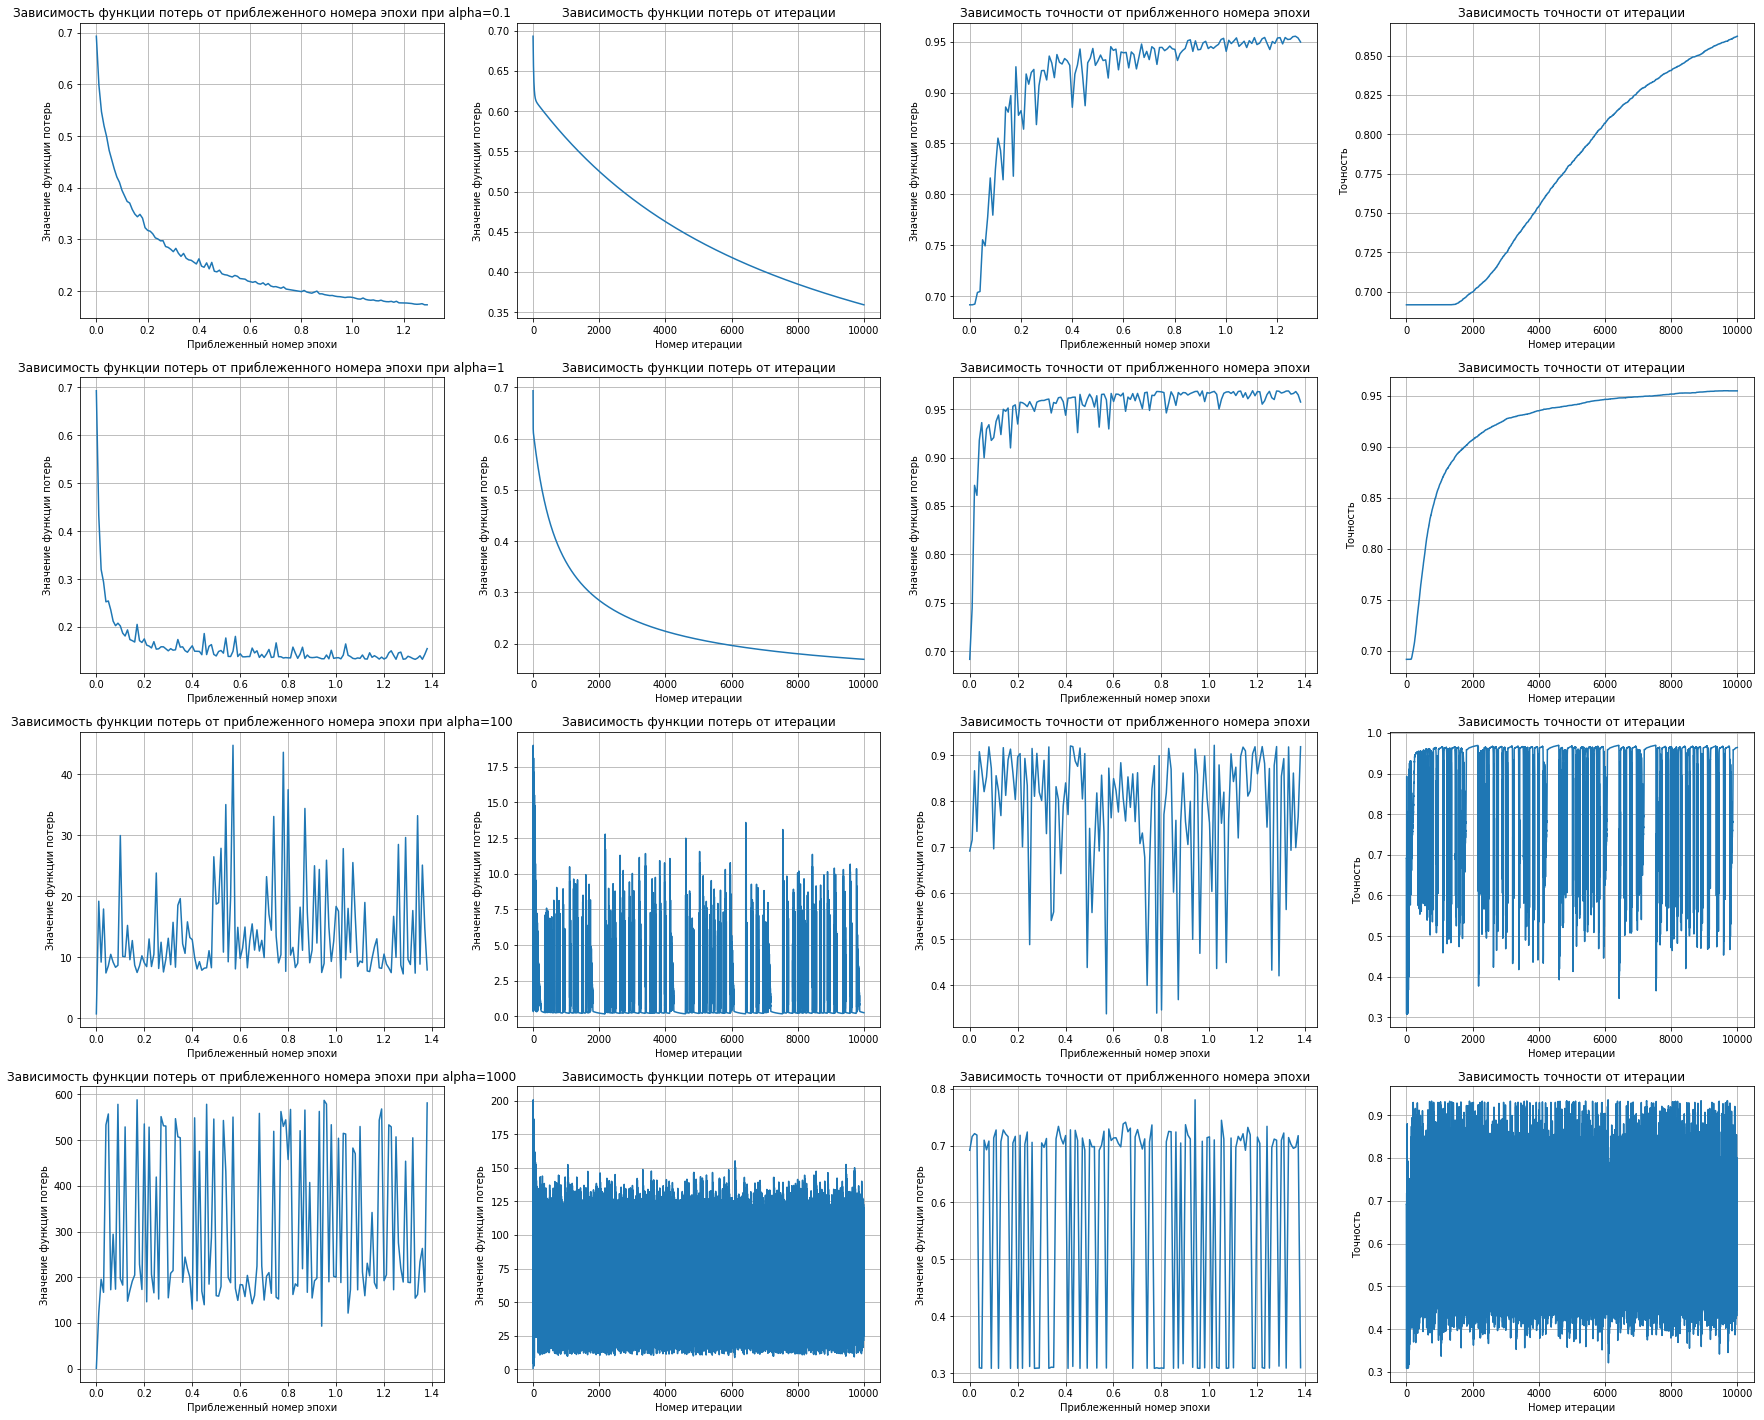

In [377]:
f, ax = plt.subplots(4, 4, figsize=(30,25))

alpha = [0.1, 1, 100, 1000]
for i, elem in enumerate(alpha):
    gd_cl = GDClassifier(max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-7, step_alpha=elem, step_beta=0)
    sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=elem, step_beta=0, batch_size=1)
    history_gd = gd_cl.fit(X, y, trace=True, accuracy=True)
    history_sgd = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
    print('SGD loss: {:.4f}, GD loss: {:.4f}, SDG accuracy: {:.4f}, GD accuracy: {:.4f}'.format(history_sgd['func'][-1],
          history_gd['func'][-1], history_sgd['accuracy'][-1], history_gd['accuracy'][-1]))
    ax[i, 0].plot(history_sgd['epoch'], history_sgd['func'])
    ax[i, 0].set_title(u"Зависимость функции потерь от приблеженного номера эпохи при alpha={}".format(elem))
    ax[i, 0].set_xlabel(u"Приблеженный номер эпохи")
    ax[i, 0].set_ylabel(u"Значение функции потерь")
    ax[i, 0].grid()
    ax[i, 0].legend()
    ax[i, 1].plot(range(len(history_gd['func'])), history_gd['func'])
    ax[i, 1].set_title(u"Зависимость функции потерь от итерации")
    ax[i, 1].set_xlabel(u"Номер итерации")
    ax[i, 1].set_ylabel(u"Значение функции потерь")
    ax[i, 1].grid()
    ax[i, 1].legend()
    ax[i, 2].plot(history_sgd['epoch'], history_sgd['accuracy'])
    ax[i, 2].set_title(u"Зависимость точности от приблженного номера эпохи")
    ax[i, 2].set_xlabel(u"Приблеженный номер эпохи")
    ax[i, 2].set_ylabel(u"Значение функции потерь")
    ax[i, 2].grid()
    ax[i, 2].legend()
    ax[i, 3].plot(range(len(history_gd['accuracy'])), history_gd['accuracy'])
    ax[i, 3].set_title(u"Зависимость точности от итерации")
    ax[i, 3].set_xlabel(u"Номер итерации")
    ax[i, 3].set_ylabel(u"Точность")
    ax[i, 3].grid()
    ax[i, 3].legend()

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


SGD loss: 23.3694, GD loss: 0.2372, SDG accuracy: 0.4957, GD accuracy: 0.9642


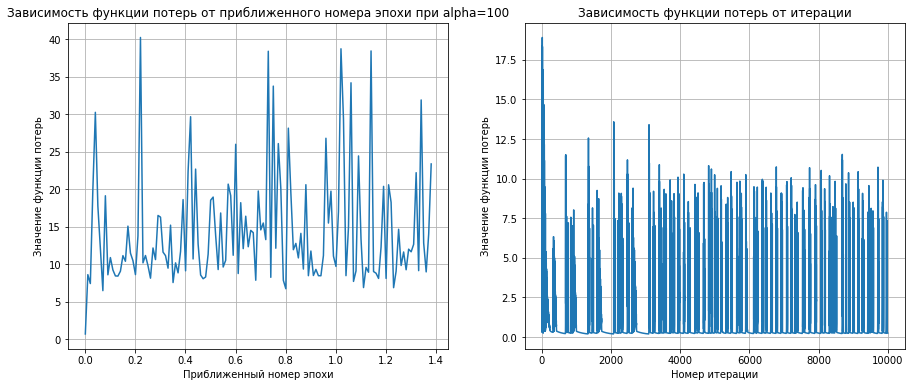

In [522]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
gd_cl = GDClassifier(max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-7, step_alpha=100, step_beta=0)
sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=100, step_beta=0, batch_size=1)
history_gd = gd_cl.fit(X, y, trace=True, accuracy=True)
history_sgd = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
print('SGD loss: {:.4f}, GD loss: {:.4f}, SDG accuracy: {:.4f}, GD accuracy: {:.4f}'.format(history_sgd['func'][-1],
          history_gd['func'][-1], history_sgd['accuracy'][-1], history_gd['accuracy'][-1]))
ax1.plot(history_sgd['epoch'], history_sgd['func'])
ax1.set_title(u"Зависимость функции потерь от приближенного номера эпохи при alpha=100")
ax1.set_xlabel(u"Приближенный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()
ax2.plot(range(len(history_gd['func'])), history_gd['func'])
ax2.set_title(u"Зависимость функции потерь от итерации")
ax2.set_xlabel(u"Номер итерации")
ax2.set_ylabel(u"Значение функции потерь")
ax2.grid()
ax2.legend()
plt.savefig("alpha100.pdf", format='pdf', bbox_inches='tight')

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


SGD loss: 0.4843, GD loss: 0.1260, SDG accuracy: 0.8999, GD accuracy: 0.9707


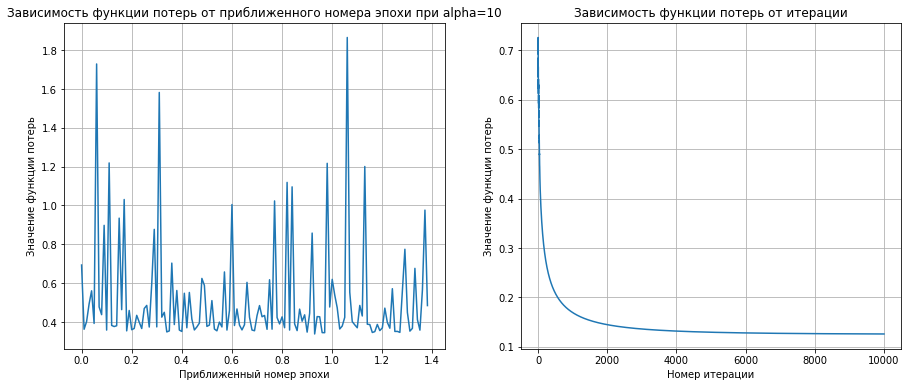

In [523]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
gd_cl = GDClassifier(max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-7, step_alpha=10, step_beta=0)
sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=10, step_beta=0, batch_size=1)
history_gd = gd_cl.fit(X, y, trace=True, accuracy=True)
history_sgd = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
print('SGD loss: {:.4f}, GD loss: {:.4f}, SDG accuracy: {:.4f}, GD accuracy: {:.4f}'.format(history_sgd['func'][-1],
          history_gd['func'][-1], history_sgd['accuracy'][-1], history_gd['accuracy'][-1]))
ax1.plot(history_sgd['epoch'], history_sgd['func'])
ax1.set_title(u"Зависимость функции потерь от приближенного номера эпохи при alpha=10")
ax1.set_xlabel(u"Приближенный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()
ax2.plot(range(len(history_gd['func'])), history_gd['func'])
ax2.set_title(u"Зависимость функции потерь от итерации")
ax2.set_xlabel(u"Номер итерации")
ax2.set_ylabel(u"Значение функции потерь")
ax2.grid()
ax2.legend()
plt.savefig("alpha1000.pdf", format='pdf', bbox_inches='tight')

SGD loss: 0.1547, GD loss: 0.1695, SDG accuracy: 0.9574, GD accuracy: 0.9546
SGD loss: 0.1504, GD loss: 0.1733, SDG accuracy: 0.9600, GD accuracy: 0.9543
SGD loss: 0.1366, GD loss: 0.2168, SDG accuracy: 0.9663, GD accuracy: 0.9381
SGD loss: 0.4122, GD loss: 0.5256, SDG accuracy: 0.8181, GD accuracy: 0.6996
SGD loss: 0.6118, GD loss: 0.6120, SDG accuracy: 0.6916, GD accuracy: 0.6916
SGD loss: 0.6227, GD loss: 0.6475, SDG accuracy: 0.6916, GD accuracy: 0.6916


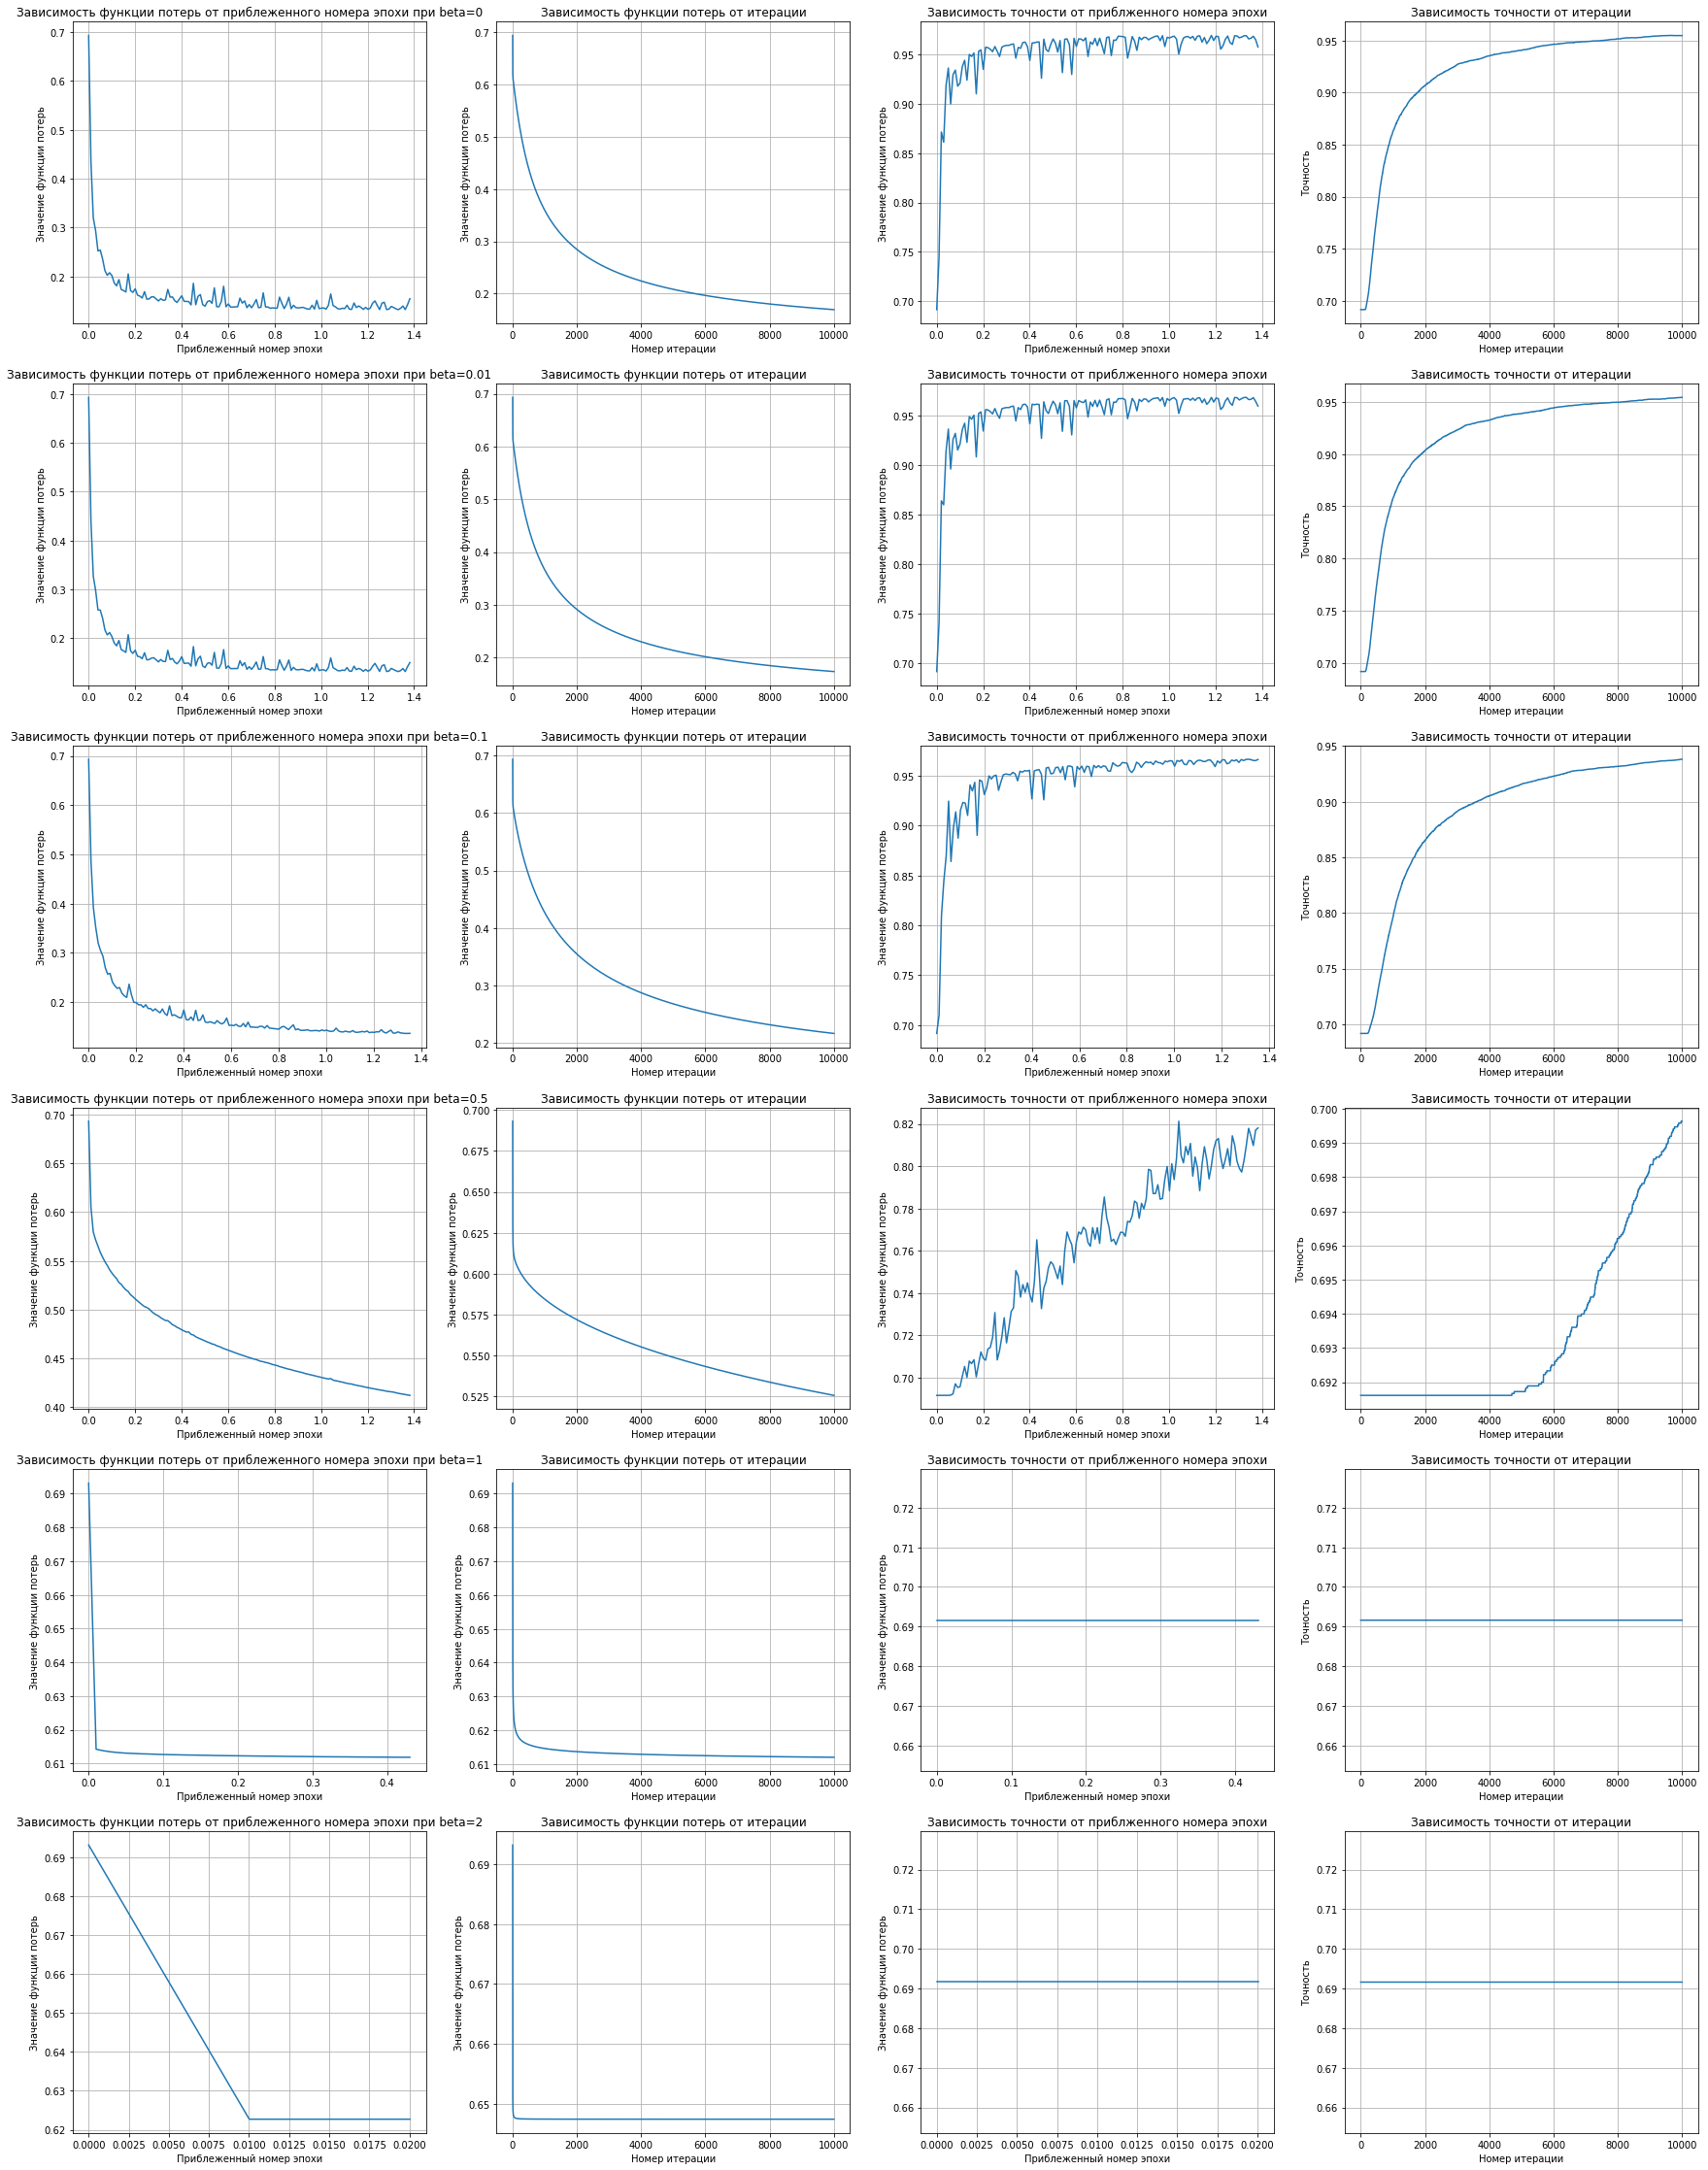

In [378]:
f, ax = plt.subplots(6, 4, figsize=(30,40))

beta = [0, 0.01, 0.1, 0.5, 1, 2]
for i, elem in enumerate(beta):
    gd_cl = GDClassifier(max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-7, step_alpha=1, step_beta=elem)
    sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=elem, batch_size=1)
    history_gd = gd_cl.fit(X, y, trace=True, accuracy=True)
    history_sgd = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
    print('SGD loss: {:.4f}, GD loss: {:.4f}, SDG accuracy: {:.4f}, GD accuracy: {:.4f}'.format(history_sgd['func'][-1],
          history_gd['func'][-1], history_sgd['accuracy'][-1], history_gd['accuracy'][-1]))
    ax[i, 0].plot(history_sgd['epoch'], history_sgd['func'])
    ax[i, 0].set_title(u"Зависимость функции потерь от приближенного номера эпохи при beta={}".format(elem))
    ax[i, 0].set_xlabel(u"Приближенный номер эпохи")
    ax[i, 0].set_ylabel(u"Значение функции потерь")
    ax[i, 0].grid()
    ax[i, 0].legend()
    ax[i, 1].plot(range(len(history_gd['func'])), history_gd['func'])
    ax[i, 1].set_title(u"Зависимость функции потерь от итерации")
    ax[i, 1].set_xlabel(u"Номер итерации")
    ax[i, 1].set_ylabel(u"Значение функции потерь")
    ax[i, 1].grid()
    ax[i, 1].legend()
    ax[i, 2].plot(history_sgd['epoch'], history_sgd['accuracy'])
    ax[i, 2].set_title(u"Зависимость точности от приближенного номера эпохи")
    ax[i, 2].set_xlabel(u"Приближенный номер эпохи")
    ax[i, 2].set_ylabel(u"Значение функции потерь")
    ax[i, 2].grid()
    ax[i, 2].legend()
    ax[i, 3].plot(range(len(history_gd['accuracy'])), history_gd['accuracy'])
    ax[i, 3].set_title(u"Зависимость точности от итерации")
    ax[i, 3].set_xlabel(u"Номер итерации")
    ax[i, 3].set_ylabel(u"Точность")
    ax[i, 3].grid()
    ax[i, 3].legend()

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


SGD loss: 0.1323, GD loss: 0.1693, SDG accuracy: 0.9685, GD accuracy: 0.9549
SGD loss: 0.1319, GD loss: 0.1731, SDG accuracy: 0.9685, GD accuracy: 0.9537
SGD loss: 0.1360, GD loss: 0.2168, SDG accuracy: 0.9655, GD accuracy: 0.9385
SGD loss: 0.4130, GD loss: 0.5252, SDG accuracy: 0.8095, GD accuracy: 0.6971
SGD loss: 0.6095, GD loss: 0.6111, SDG accuracy: 0.6892, GD accuracy: 0.6892
SGD loss: 0.7321, GD loss: 0.6470, SDG accuracy: 0.3108, GD accuracy: 0.6892


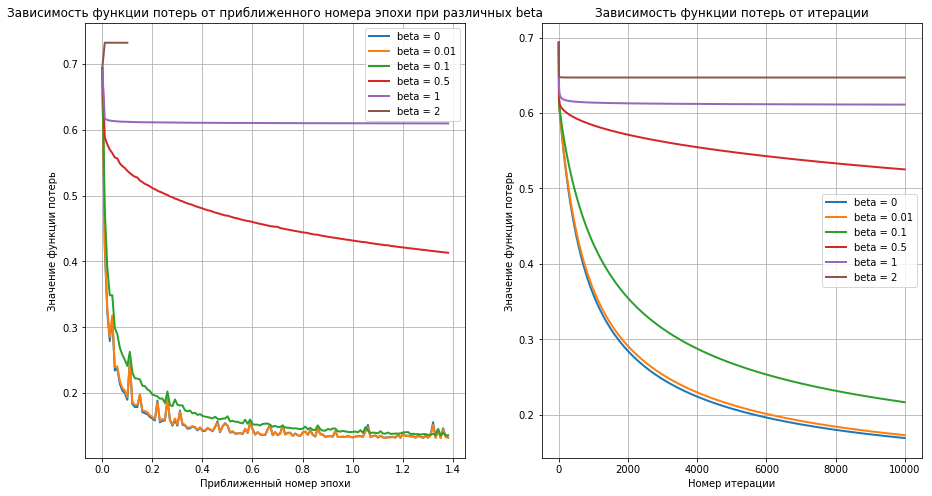

In [524]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

beta = [0, 0.01, 0.1, 0.5, 1, 2]
for i, elem in enumerate(beta):
    gd_cl = GDClassifier(max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-6, step_alpha=1, step_beta=elem)
    sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-6, step_alpha=1, step_beta=elem, batch_size=1)
    history_gd = gd_cl.fit(X, y, trace=True, accuracy=True)
    history_sgd = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
    print('SGD loss: {:.4f}, GD loss: {:.4f}, SDG accuracy: {:.4f}, GD accuracy: {:.4f}'.format(history_sgd['func'][-1],
          history_gd['func'][-1], history_sgd['accuracy'][-1], history_gd['accuracy'][-1]))
    ax1.plot(history_sgd['epoch'], history_sgd['func'], label=u"beta = {}".format(elem), linewidth=2)
    ax2.plot(range(len(history_gd['func'])), history_gd['func'], label=u"beta = {}".format(elem), linewidth=2)
ax1.set_title(u"Зависимость функции потерь от приближенного номера эпохи при различных beta")
ax1.set_xlabel(u"Приближенный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()
ax2.set_title(u"Зависимость функции потерь от итерации")
ax2.set_xlabel(u"Номер итерации")
ax2.set_ylabel(u"Значение функции потерь")
ax2.grid()
ax2.legend()
plt.savefig("beta.pdf", format='pdf', bbox_inches='tight')            

## Эксперимент №3

SGD loss: 0.1460,SDG accuracy: 0.9608
SGD loss: 0.1355,SDG accuracy: 0.9663
SGD loss: 0.1359,SDG accuracy: 0.9690
SGD loss: 0.1353,SDG accuracy: 0.9670
SGD loss: 0.1345,SDG accuracy: 0.9687
SGD loss: 0.1344,SDG accuracy: 0.9661
SGD loss: 0.1397,SDG accuracy: 0.9617
SGD loss: 0.1373,SDG accuracy: 0.9631
SGD loss: 0.1348,SDG accuracy: 0.9672
SGD loss: 0.1381,SDG accuracy: 0.9638


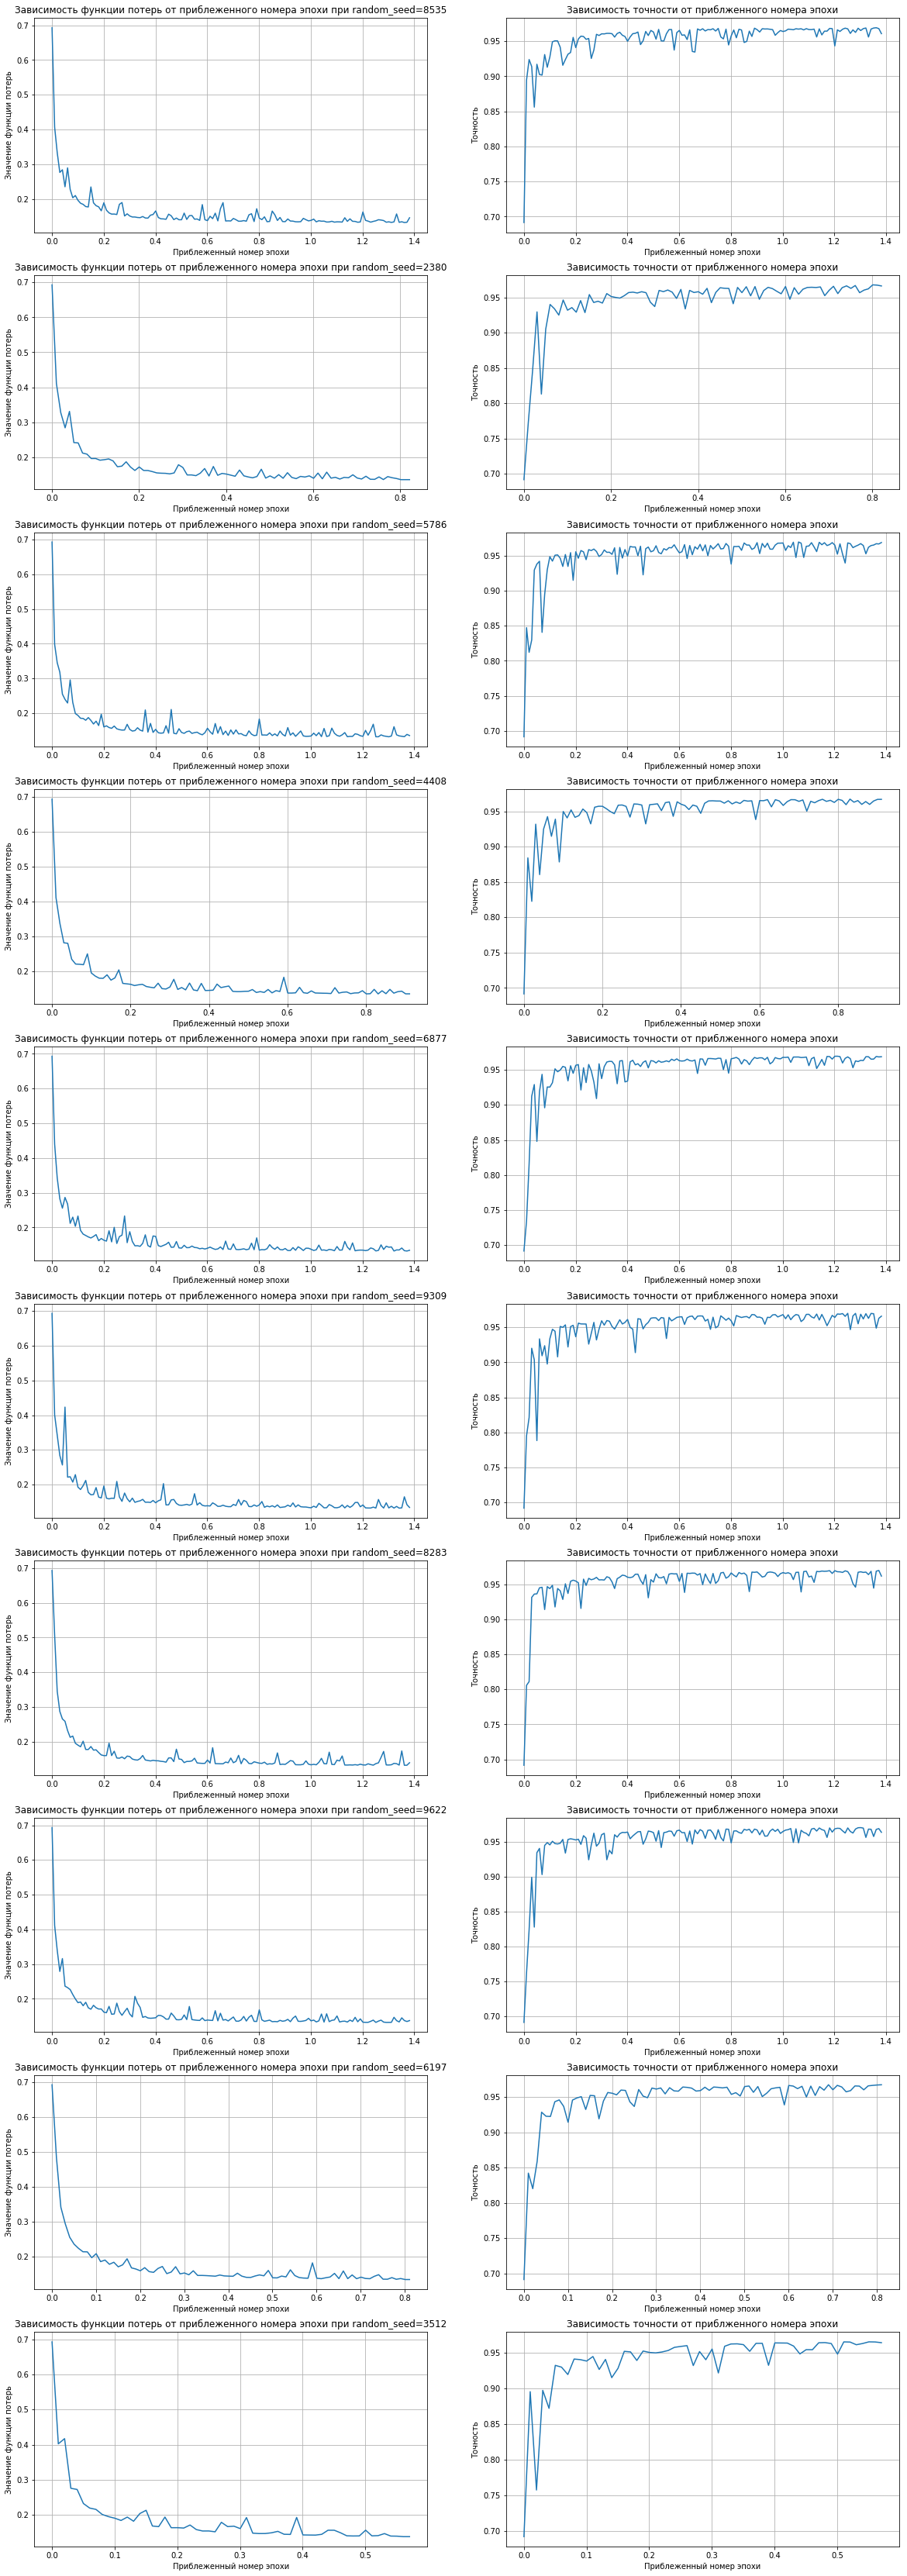

In [379]:
f, ax = plt.subplots(10, 2, figsize=(20,60))

rand_seed = np.random.randint(0, 10000, 10)
for i, elem in enumerate(rand_seed):
    sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=0, batch_size=1, random_seed=elem)
    history = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
    print('SGD loss: {:.4f},SDG accuracy: {:.4f}'.format(history['func'][-1], history['accuracy'][-1]))
    ax[i, 0].plot(history['epoch'], history['func'])
    ax[i, 0].set_title(u"Зависимость функции потерь от приблеженного номера эпохи при random_seed={}".format(elem))
    ax[i, 0].set_xlabel(u"Приблеженный номер эпохи")
    ax[i, 0].set_ylabel(u"Значение функции потерь")
    ax[i, 0].grid()
    ax[i, 0].legend()
    ax[i, 1].plot(history['epoch'], history['accuracy'])
    ax[i, 1].set_title(u"Зависимость точности от приблженного номера эпохи")
    ax[i, 1].set_xlabel(u"Приблеженный номер эпохи")
    ax[i, 1].set_ylabel(u"Точность")
    ax[i, 1].grid()
    ax[i, 1].legend()

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


SGD loss: 0.1359,SDG accuracy: 0.9641
SGD loss: 0.1342,SDG accuracy: 0.9660


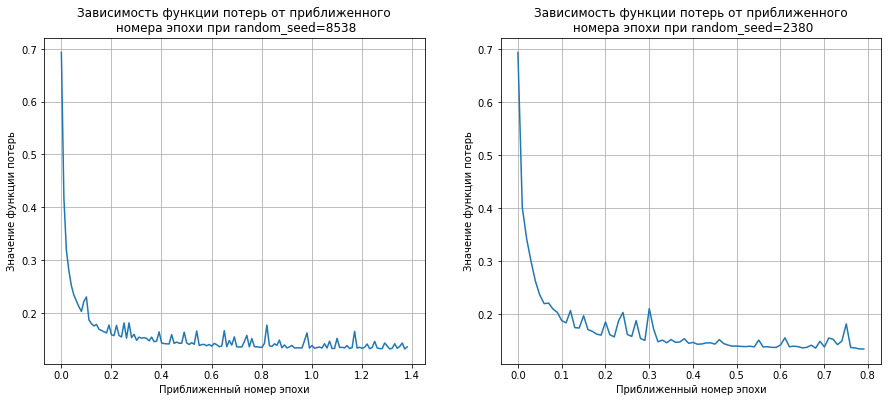

In [525]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=0, batch_size=1, random_seed=8535)
history = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
print('SGD loss: {:.4f},SDG accuracy: {:.4f}'.format(history['func'][-1], history['accuracy'][-1]))
ax1.plot(history['epoch'], history['func'])
ax1.set_title(u"Зависимость функции потерь от приближенного\n номера эпохи при random_seed={}".format(8538))
ax1.set_xlabel(u"Приближенный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()
sgd_cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=0, batch_size=1, random_seed=2380)
history = sgd_cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
print('SGD loss: {:.4f},SDG accuracy: {:.4f}'.format(history['func'][-1], history['accuracy'][-1]))
ax2.plot(history['epoch'], history['func'])
ax2.set_title(u"Зависимость функции потерь от приближенного\n номера эпохи при random_seed={}".format(2380))
ax2.set_xlabel(u"Приближенный номер эпохи")
ax2.set_ylabel(u"Значение функции потерь")
ax2.grid()
ax2.legend()
plt.savefig("rs.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Эксперимент№4

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


SGD loss: 0.1323,SDG accuracy: 0.9685
SGD loss: 0.1281,SDG accuracy: 0.9705
SGD loss: 0.1290,SDG accuracy: 0.9688
SGD loss: 0.1309,SDG accuracy: 0.9681
SGD loss: 0.1588,SDG accuracy: 0.9588
SGD loss: 0.2180,SDG accuracy: 0.9346


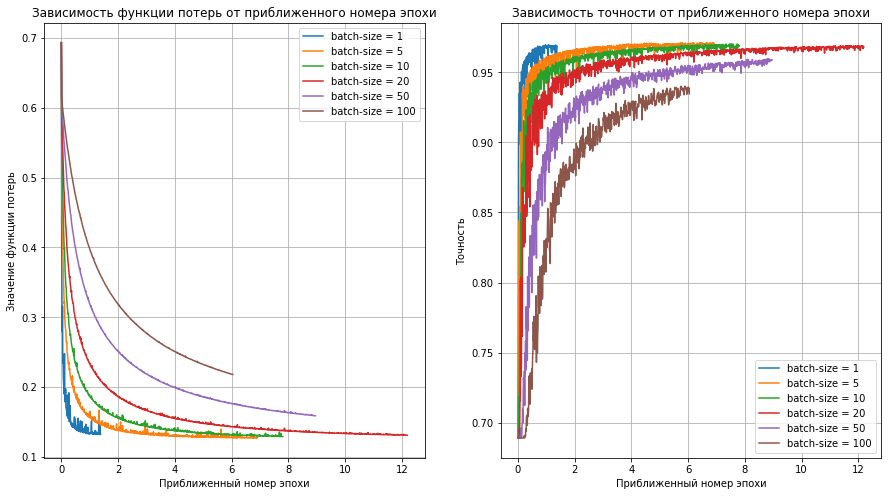

In [526]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
batch = [1, 5, 10, 20, 50, 100]

for i, elem in enumerate(batch):
    cl = SGDClassifier(max_iter=100000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-6, step_alpha=1, step_beta=0, batch_size=elem)
    history = cl.fit(X, y, log_freq=0.01, trace=True, accuracy=True)
    print('SGD loss: {:.4f},SDG accuracy: {:.4f}'.format(history['func'][-1], history['accuracy'][-1]))
    ax1.plot(history['epoch'], history['func'], label=u"batch-size = {}".format(elem), linewidth=1.5)
    ax2.plot(history['epoch'], history['accuracy'], label=u"batch-size = {}".format(elem), linewidth=1.5)
ax1.set_title(u"Зависимость функции потерь от приближенного номера эпохи")
ax1.set_xlabel(u"Приближенный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()
ax2.set_title(u"Зависимость точности от приближенного номера эпохи")
ax2.set_xlabel(u"Приближенный номер эпохи")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()
plt.savefig("batch_size.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Эксперимент №5

In [419]:
cl_st = StandardScaler()
X, y = make_blobs(n_samples=300, cluster_std=1, center_box=(-5, 5), random_state=134)
X = cl_st.fit_transform(X)

In [420]:
cl = MulticlassStrategy(SGDClassifier, mode='one_vs_all', max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=0, batch_size=5)
cl.fit(X, y)

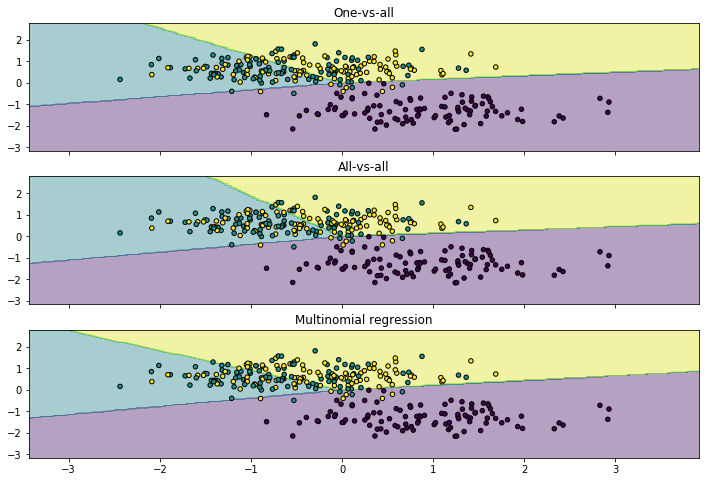

In [421]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
y_score = (cl.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(12, 8))
ax1.contourf(xx, yy, y_score, alpha=0.4)
ax1.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
ax1.set_title('One-vs-all')
cl = MulticlassStrategy(SGDClassifier, mode='all_vs_all', max_iter=10000, loss_function='binary_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=0, batch_size=5)
cl.fit(X, y)
y_score = (cl.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
#f, ax = plt.subplots(sharex='col', sharey='row', figsize=(10, 8))
ax2.contourf(xx, yy, y_score, alpha=0.4)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
ax2.set_title('All-vs-all')
#plt.savefig("one_vs_all.pdf", format='pdf', bbox_inches='tight')
#plt.show()
cl = SGDClassifier(max_iter=10000, loss_function='multinomial_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=0, batch_size=5, class_number=3)
cl.fit(X, y)
y_score = (cl.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
#f, ax = plt.subplots(sharex='col', sharey='row', figsize=(10, 8))
ax3.contourf(xx, yy, y_score, alpha=0.4)
ax3.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
ax3.set_title('Multinomial regression')
plt.savefig("multiclass.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Эксперимент №6

In [423]:
data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'quotes', 'footers'))

In [424]:
data.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [425]:
def edit_text(elem):
    return ' '.join([elem for elem in re.split('\W+', str.lower(elem))])

In [426]:
pool = Pool()
data.data = pool.map(edit_text, data.data)
pool.close()
pool.join()

In [427]:
data.data[0]

'i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail '

## Эксперимент №7

In [511]:
cl_vectorizer = CountVectorizer()
X = cl_vectorizer.fit_transform(data.data)

In [512]:
X_train, X_test, y_train, y_test = train_test_split(X, data.target, random_state=11, train_size=0.7)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [513]:
X_train = (sparse.hstack((np.ones((X_train.shape[0], 1)), X_train))).tocsr()
X_test = (sparse.hstack((np.ones((X_test.shape[0], 1)), X_test))).tocsr()

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


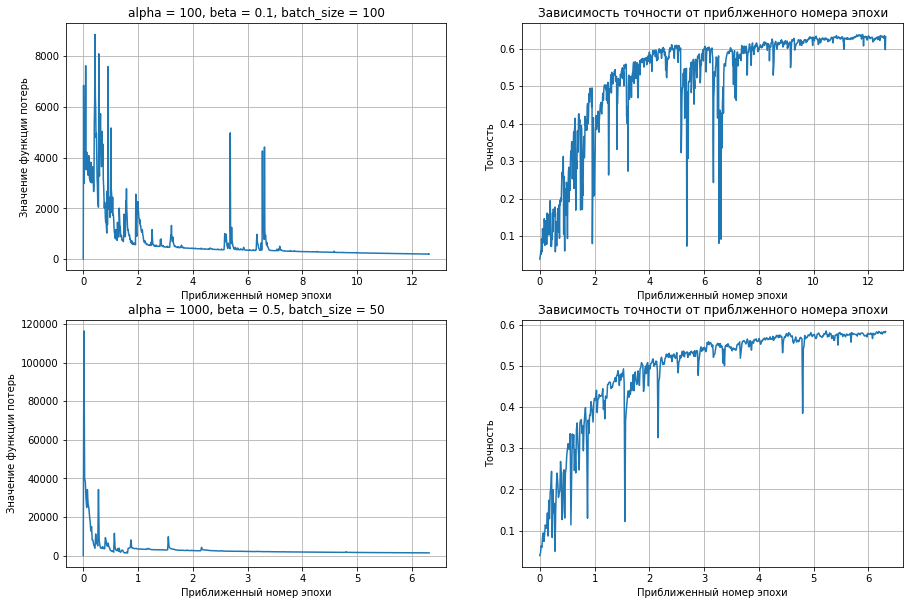

In [514]:
f, ax = plt.subplots(2, 2, figsize=(15,10))


cl_sgd = SGDClassifier(max_iter=1000, loss_function='multinomial_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=100, step_beta=0.1, batch_size=100, class_number=20)
history = cl_sgd.fit(X_train, y_train, log_freq=0.01, trace=True, accuracy=True)

ax[0, 0].plot(history['epoch'], history['func'])
ax[0, 0].set_title(u"alpha = 100, beta = 0.1, batch_size = 100")
ax[0, 0].set_xlabel(u"Приближенный номер эпохи")
ax[0, 0].set_ylabel(u"Значение функции потерь")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].plot(history['epoch'], history['accuracy'])
ax[0, 1].set_title(u"Зависимость точности от приблженного номера эпохи")
ax[0, 1].set_xlabel(u"Приближенный номер эпохи")
ax[0, 1].set_ylabel(u"Точность")
ax[0, 1].grid()
ax[0, 1].legend()

cl_sgd = SGDClassifier(max_iter=1000, loss_function='multinomial_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1000, step_beta=0.5, batch_size=50, class_number=20)
history = cl_sgd.fit(X_train, y_train, log_freq=0.01, trace=True, accuracy=True)

ax[1, 0].plot(history['epoch'], history['func'])
ax[1, 0].set_title(u"alpha = 1000, beta = 0.5, batch_size = 50")
ax[1, 0].set_xlabel(u"Приближенный номер эпохи")
ax[1, 0].set_ylabel(u"Значение функции потерь")
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].plot(history['epoch'], history['accuracy'])
ax[1, 1].set_title(u"Зависимость точности от приблженного номера эпохи")
ax[1, 1].set_xlabel(u"Приближенный номер эпохи")
ax[1, 1].set_ylabel(u"Точность")
ax[1, 1].grid()
ax[1, 1].legend()


plt.savefig("bagofwords.pdf", format='pdf', bbox_inches='tight')

## Эксперимент №8

In [495]:
cl_tf_idf_vectorizer = TfidfVectorizer()
X = cl_tf_idf_vectorizer.fit_transform(data.data)
X = (sparse.hstack((np.ones((X.shape[0], 1)), X))).tocsr()

In [496]:
X_train, X_test, y_train, y_test = train_test_split(X, data.target, random_state=11, train_size=0.7)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1108]:
alpha_list = [0.1, 1, 100, 1000]
beta_list = [0, 0.01, 0.1, 0.5, 1, 2]
batch_size_list = [1, 5, 10, 20, 50, 100]

f, ax = plt.subplots(144, 2, figsize=(20,900))

i = 0
for alpha in alpha_list:
    for beta in beta_list:
        for batch_size in batch_size_list:
            sgd_cl = SGDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=alpha, step_beta=beta, batch_size=batch_size, random_seed=141, class_number=20)
            history = sgd_cl.fit(X_train, y_train, log_freq=0.01, trace=True, accuracy=True)
            print('alpha = {}, beta = {}, batch_size = {}'.format(alpha, beta, batch_size))
            print('SGD loss: {:.4f},SDG accuracy: {:.4f}'.format(history['func'][-1], history['accuracy'][-1]))
            ax[i, 0].plot(history['epoch'], history['func'])
            ax[i, 0].set_title(u"Зависимость функции потерь от приблеженного номера эпохи при {}, {}, {}".format(alpha, beta, batch_size))
            ax[i, 0].set_xlabel(u"Приблеженный номер эпохи")
            ax[i, 0].set_ylabel(u"Значение функции потерь")
            ax[i, 0].grid()
            ax[i, 0].legend()
            ax[i, 1].plot(history['epoch'], history['accuracy'])
            ax[i, 1].set_title(u"Зависимость точности от приблженного номера эпохи")
            ax[i, 1].set_xlabel(u"Приблеженный номер эпохи")
            ax[i, 1].set_ylabel(u"Точность")
            ax[i, 1].grid()
            ax[i, 1].legend()
            i += 1

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


alpha = 0.1, beta = 0, batch_size = 1
SGD loss: 2.8524,SDG accuracy: 0.2075
alpha = 0.1, beta = 0, batch_size = 5
SGD loss: 2.8380,SDG accuracy: 0.2858
alpha = 0.1, beta = 0, batch_size = 10
SGD loss: 2.9490,SDG accuracy: 0.1221
alpha = 0.1, beta = 0, batch_size = 20
SGD loss: 2.9007,SDG accuracy: 0.2088
alpha = 0.1, beta = 0, batch_size = 50
SGD loss: 2.9808,SDG accuracy: 0.0867
alpha = 0.1, beta = 0, batch_size = 100
SGD loss: 2.9921,SDG accuracy: 0.0598
alpha = 0.1, beta = 0.01, batch_size = 1
SGD loss: 2.8605,SDG accuracy: 0.1944
alpha = 0.1, beta = 0.01, batch_size = 5
SGD loss: 2.8473,SDG accuracy: 0.2706
alpha = 0.1, beta = 0.01, batch_size = 10
SGD loss: 2.9102,SDG accuracy: 0.1258
alpha = 0.1, beta = 0.01, batch_size = 20
SGD loss: 2.9058,SDG accuracy: 0.1991
alpha = 0.1, beta = 0.01, batch_size = 50
SGD loss: 2.9891,SDG accuracy: 0.0539
alpha = 0.1, beta = 0.01, batch_size = 100
SGD loss: 2.9922,SDG accuracy: 0.0606
alpha = 0.1, beta = 0.1, batch_size = 1
SGD loss: 2.9149,SDG

alpha = 100, beta = 2, batch_size = 50
SGD loss: 3.5314,SDG accuracy: 0.2180
alpha = 100, beta = 2, batch_size = 100
SGD loss: 2.9499,SDG accuracy: 0.2622
alpha = 1000, beta = 0, batch_size = 1
SGD loss: 1221.4477,SDG accuracy: 0.0505
alpha = 1000, beta = 0, batch_size = 5
SGD loss: 527.4865,SDG accuracy: 0.1052
alpha = 1000, beta = 0, batch_size = 10
SGD loss: 363.2586,SDG accuracy: 0.1275
alpha = 1000, beta = 0, batch_size = 20
SGD loss: 431.7026,SDG accuracy: 0.1052
alpha = 1000, beta = 0, batch_size = 50
SGD loss: 332.7761,SDG accuracy: 0.1637
alpha = 1000, beta = 0, batch_size = 100
SGD loss: 219.8752,SDG accuracy: 0.2201
alpha = 1000, beta = 0.01, batch_size = 1
SGD loss: 1116.7392,SDG accuracy: 0.0509
alpha = 1000, beta = 0.01, batch_size = 5
SGD loss: 550.6788,SDG accuracy: 0.0589
alpha = 1000, beta = 0.01, batch_size = 10
SGD loss: 376.2080,SDG accuracy: 0.1040
alpha = 1000, beta = 0.01, batch_size = 20
SGD loss: 385.5447,SDG accuracy: 0.0804
alpha = 1000, beta = 0.01, batch_s

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
cl_sgd = SGDClassifier(max_iter=5000, loss_function='multinomial_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1000, step_beta=0.5, batch_size=50, class_number=20)
history = cl_sgd.fit(X_train, y_train, log_freq=0.01, trace=True, accuracy=True)

In [1113]:
history['accuracy'][-1], history['func'][-1]

0.71927609427609429

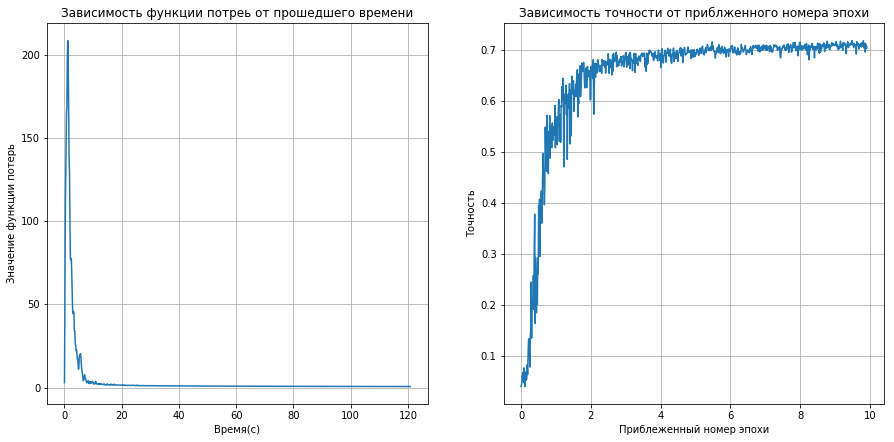

In [1110]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(history['epoch'], history['func'])
ax1.set_title(u"Зависимость функции потреь от прошедшего времени")
ax1.set_xlabel(u"Приблеженный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()

ax2.plot(history['epoch'], history['accuracy'])
ax2.set_title(u"Зависимость точности от приблженного номера эпохи")
ax2.set_xlabel(u"Приблеженный номер эпохи")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

In [1114]:
cl_sgd = SGDClassifier(max_iter=5000, loss_function='multinomial_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=100, step_beta=0.1, batch_size=100, class_number=20)
history = cl_sgd.fit(X_train, y_train, log_freq=0.01, trace=True, accuracy=True)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1116]:
history['accuracy'][-1], history['func'][-1]

(0.71464646464646464, 0.51868446709191396)

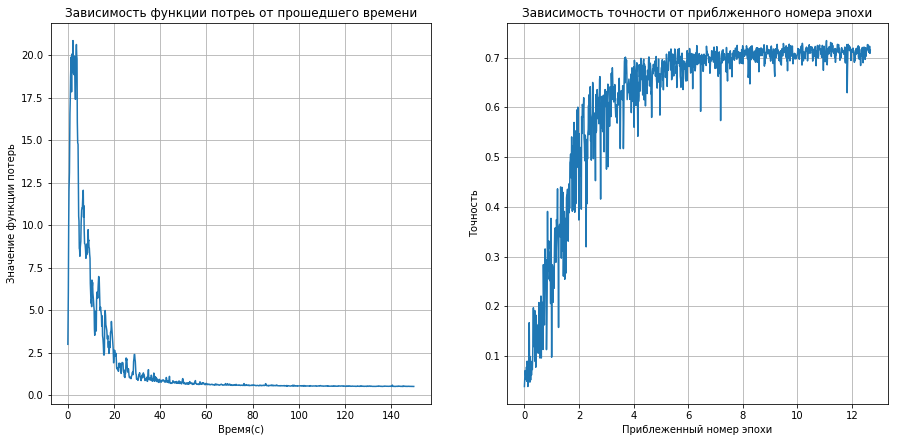

In [1115]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(history['time'], history['func'])
ax1.set_title(u"Зависимость функции потреь от прошедшего времени")
ax1.set_xlabel(u"Время(с)")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()

ax2.plot(history['epoch'], history['accuracy'])
ax2.set_title(u"Зависимость точности от приблженного номера эпохи")
ax2.set_xlabel(u"Приблеженный номер эпохи")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

In [1118]:
cl_sgd = SGDClassifier(max_iter=5000, loss_function='multinomial_logistic',l2_coef=1e-5, tolerance=1e-5, step_alpha=1, step_beta=0, batch_size=5, class_number=20)
history = cl_sgd.fit(X_train, y_train, log_freq=0.01, trace=True, accuracy=True)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1119]:
history['accuracy'][-1], history['func'][-1]

(0.7087542087542088, 0.88685698725724826)

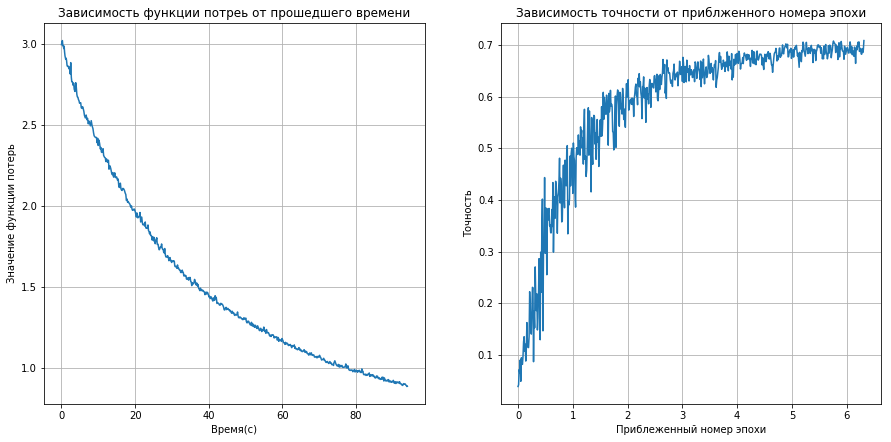

In [1120]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(history['time'], history['func'])
ax1.set_title(u"Зависимость функции потреь от прошедшего времени")
ax1.set_xlabel(u"Время(с)")
ax1.set_ylabel(u"Значение функции потерь")
ax1.grid()
ax1.legend()

ax2.plot(history['epoch'], history['accuracy'])
ax2.set_title(u"Зависимость точности от приблженного номера эпохи")
ax2.set_xlabel(u"Приблеженный номер эпохи")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


SGD loss: 0.1892,SDG accuracy: 0.7247
SGD loss: 0.5894,SDG accuracy: 0.6856
SGD loss: 2.3798,SDG accuracy: 0.3224
SGD loss: 5.8910,SDG accuracy: 0.0896
SGD loss: 6.4074,SDG accuracy: 0.0484


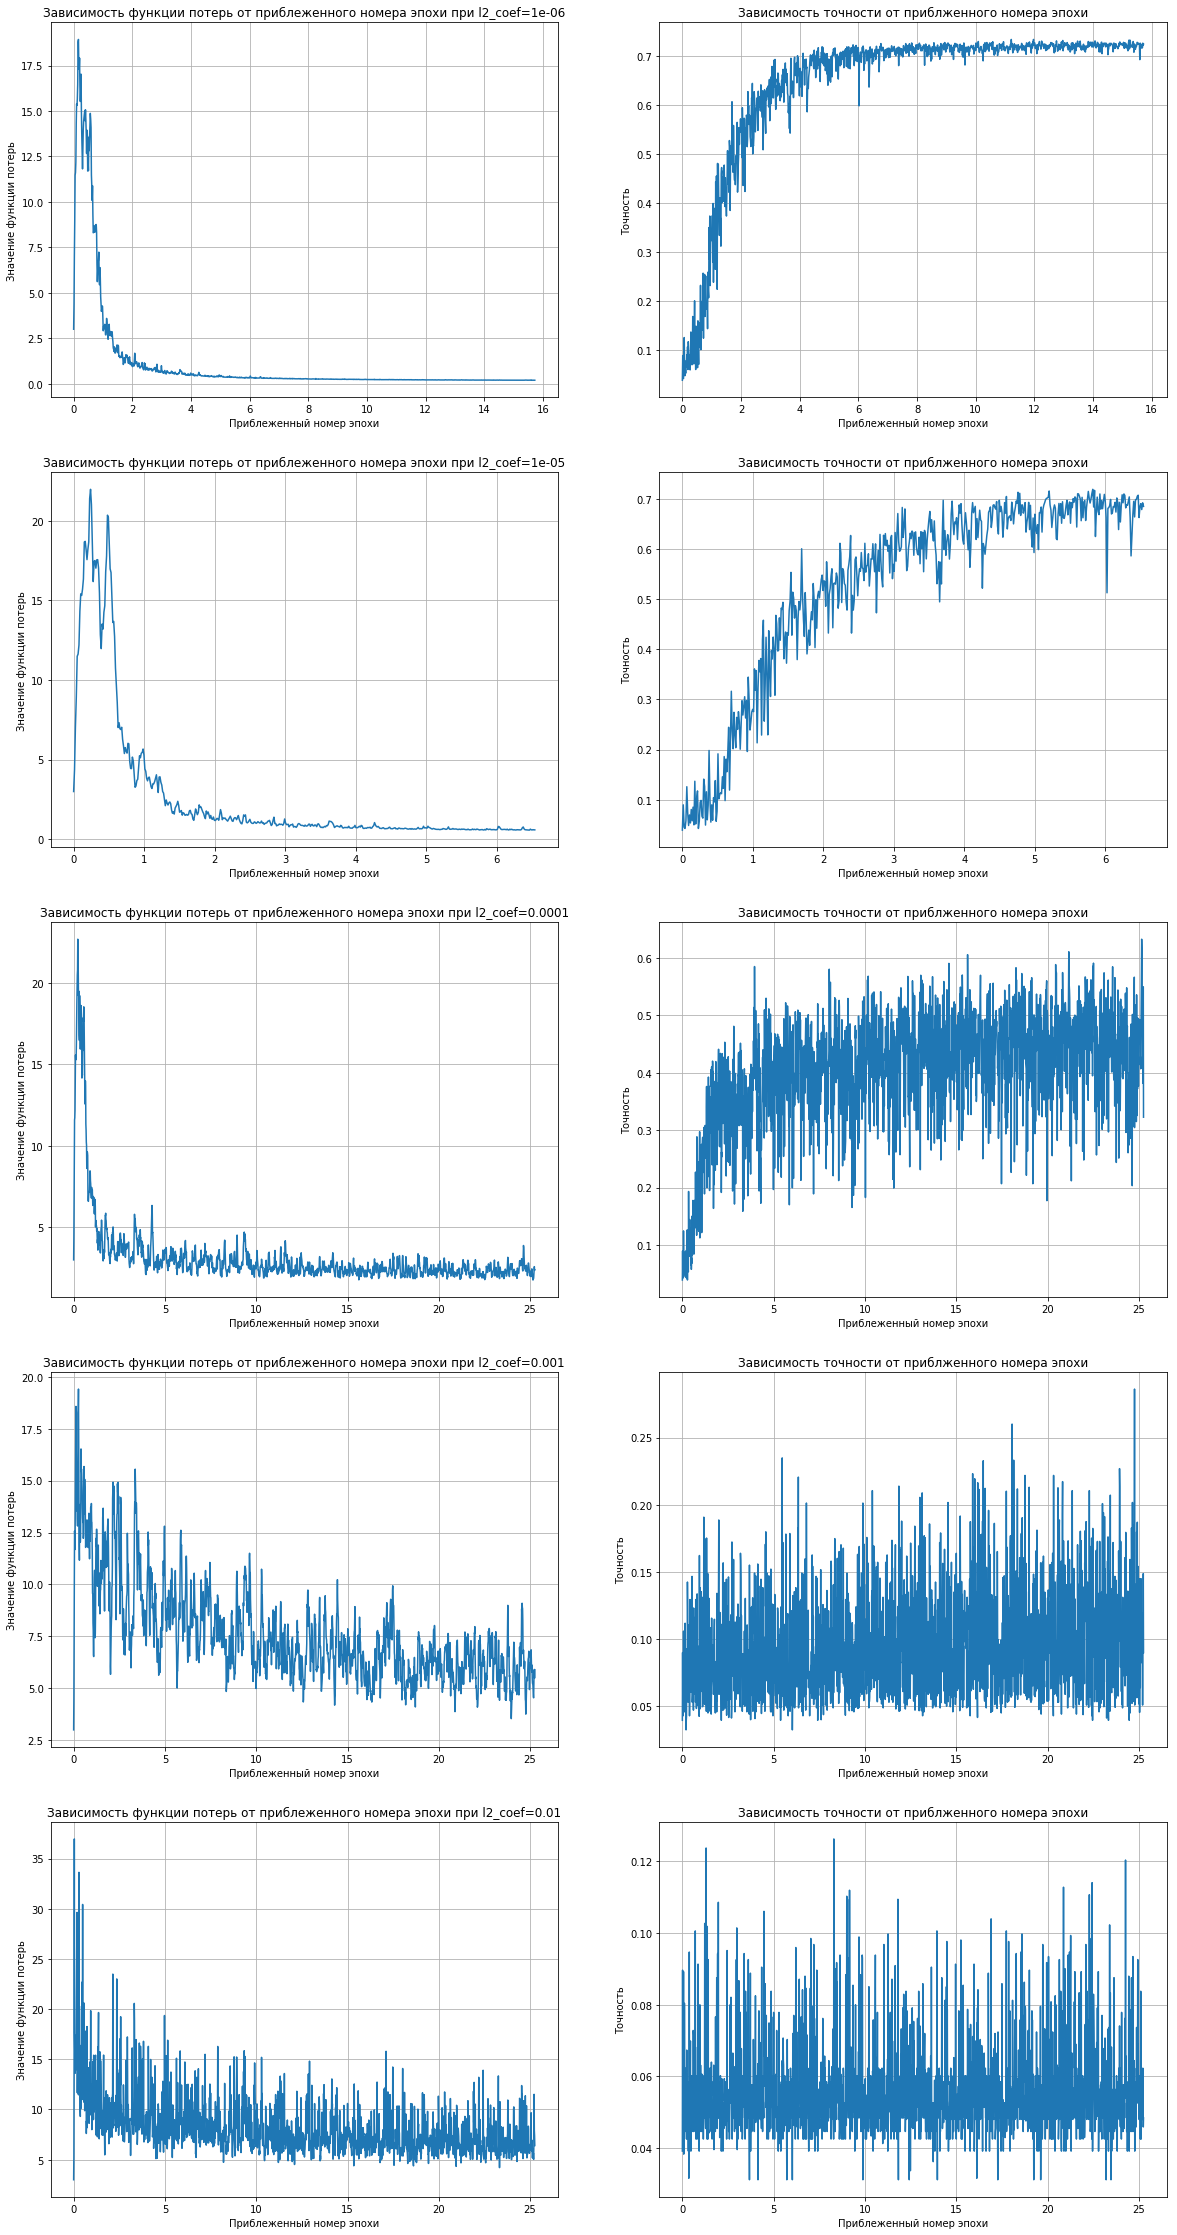

In [1125]:
l2_list = [1e-6, 1e-5, 1e-4, 0.001, 0.01]

f, ax = plt.subplots(5, 2, figsize=(20,40))

for i, elem in enumerate(l2_list):
    cl_sgd = SGDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=elem, tolerance=1e-5, step_alpha=100, step_beta=0.1, random_seed=141, batch_size=100, class_number=20)
    history = cl_sgd.fit(X_train, y_train, log_freq=0.01, trace=True, accuracy=True)
    print('SGD loss: {:.4f},SDG accuracy: {:.4f}'.format(history['func'][-1], history['accuracy'][-1]))
    ax[i, 0].plot(history['epoch'], history['func'])
    ax[i, 0].set_title(u"Зависимость функции потерь от приблеженного номера эпохи при l2_coef={}".format(elem))
    ax[i, 0].set_xlabel(u"Приближенный номер эпохи")
    ax[i, 0].set_ylabel(u"Значение функции потерь")
    ax[i, 0].grid()
    ax[i, 0].legend()
    ax[i, 1].plot(history['epoch'], history['accuracy'])
    ax[i, 1].set_title(u"Зависимость точности от приблженного номера эпохи")
    ax[i, 1].set_xlabel(u"Приблеженный номер эпохи")
    ax[i, 1].set_ylabel(u"Точность")
    ax[i, 1].grid()
    ax[i, 1].legend()

In [508]:
cl_sgd = SGDClassifier(max_iter=10000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, random_seed=141, batch_size=100, class_number=20)
history = cl_sgd.fit(X_train, y_train, log_freq=0.1, trace=True, accuracy=True)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [509]:
history['accuracy'][-1], history['func'][-1]

(0.72727272727272729, 0.15846338211246458)

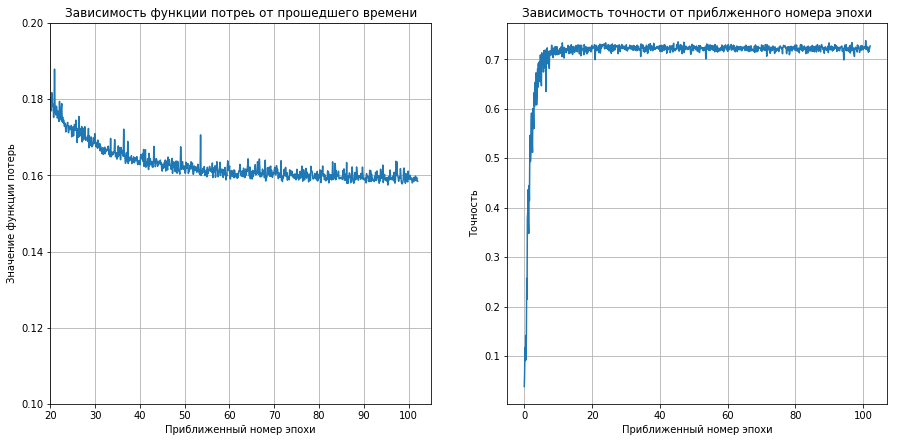

In [510]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(history['epoch'], history['func'])
ax1.set_title(u"Зависимость функции потреь от прошедшего времени")
ax1.set_xlabel(u"Приближенный номер эпохи")
ax1.set_ylabel(u"Значение функции потерь")
ax1.set_ylim([0.1, 0.2])
ax1.set_xlim([20, 105])
ax1.grid()
ax1.legend()

ax2.plot(history['epoch'], history['accuracy'])
ax2.set_title(u"Зависимость точности от приблженного номера эпохи")
ax2.set_xlabel(u"Приближенный номер эпохи")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()
plt.savefig("maxitersgd.pdf", format='pdf', bbox_inches='tight')

In [505]:
cl_fgd = GDClassifier(max_iter=5000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-5, step_alpha=100, step_beta=0.1, class_number=20)
history_fgd = cl_fgd.fit(X_train, y_train, trace=True, accuracy=True)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [506]:
history_fgd['accuracy'][-1], history_fgd['func'][-1]

(0.72937710437710435, 0.15738004160358088)

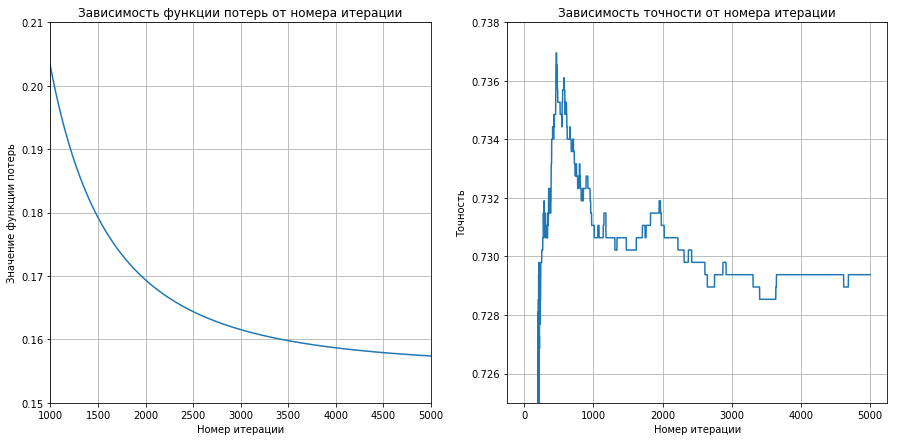

In [507]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(range(len(history_fgd['func'])), history_fgd['func'])
ax1.set_title(u"Зависимость функции потерь от номера итерации")
ax1.set_xlabel(u"Номер итерации")
ax1.set_ylabel(u"Значение функции потерь")
ax1.set_xlim([1000, 5000])
ax1.set_ylim([0.15, 0.21])
ax1.grid()
ax1.legend()

ax2.plot(range(len(history_fgd['accuracy'])), history_fgd['accuracy'])
ax2.set_title(u"Зависимость точности от номера итерации")
ax2.set_xlabel(u"Номер итерации")
ax2.set_ylabel(u"Точность")
ax2.set_ylim([0.725, 0.738])
ax2.grid()
ax2.legend()

plt.savefig("maxitergd.pdf", format='pdf', bbox_inches='tight')

Из графика видно, что стохастическая модель сходится примерно за 8000 итераций, причем убывание функции потерь на последних 40 эпохах составляет порядка 0.02. Из графика для полного градиентного спуска видно, что несмотря на убывание функции потерь, после двухтысячной итерации качество на отложенной выбрке начинает падать, что может означать переобучение модели.

## Эксперимент №9

In [459]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [460]:
data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'quotes', 'footers'))

In [503]:
data_test.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [461]:
pool = Pool()
data_test.data = pool.map(edit_text, data_test.data)
pool.close()
pool.join()

In [462]:
cl_tf_idf_vectorizer.fit(data.data)
test_data = cl_tf_idf_vectorizer.transform(data_test.data)
test_data = (sparse.hstack((np.ones((test_data.shape[0], 1)), test_data))).tocsr()

In [477]:
cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

In [478]:
%time history = cl_gd.fit(X, data.target, trace=True)

CPU times: user 19min 6s, sys: 1min 7s, total: 20min 14s
Wall time: 57min 22s


In [479]:
print(X.shape, test_data.shape)
preds = cl_gd.predict(test_data)
accuracy = (preds == data_test.target).sum() / data_test.target.shape[0]
print(accuracy)

(11314, 101632) (7532, 101632)
0.683616569304


Confusion matrix, without normalization


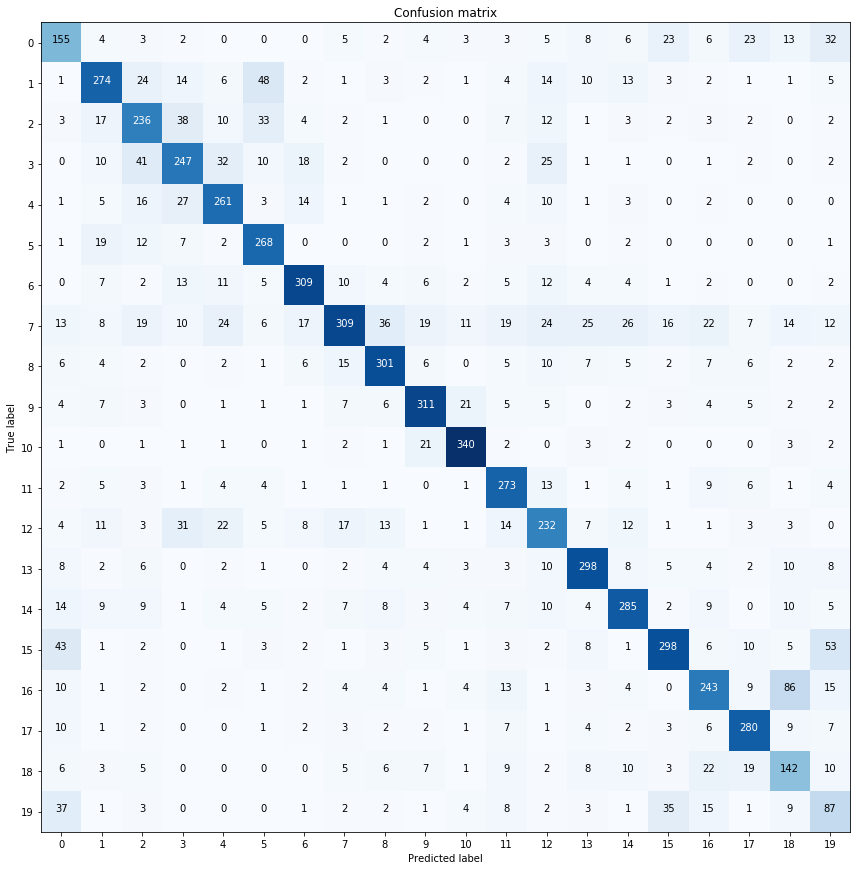

In [498]:
cm = confusion_matrix(preds, data_test.target)
plt.figure(figsize=(20, 12))
plot_confusion_matrix(cm, classes = np.unique(data_test.target).astype(int), title='Confusion matrix')
plt.savefig("cm.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [504]:
misses = np.arange(data_test.target.shape[0])[preds != data_test.target]
subset = np.random.choice(misses, 10)
for i in subset:
    print('text:')
    print(data_test.data[i])
    print('true label: {}, predicted label: {}'.format(data_test.target_names[data_test.target[i]], data_test.target_names[preds[i]]))

text:
 we don t disagree on this all i said was that a right is whatever you or somebody acting for you can enforce the bill of rights didn t come into effect until it was ratified by the states and indirectly the people from that point it defined legal rights common law rights are vague and situational that s why the people insisted on a bill of rights in the constitution spelling out exactly what they demanded from the government legitimate or illegitimate power is power that s why the federal government can force states to grant their citizens rights they don t wish to in a slugging match the feds win period and you re right this doesn t belong in sci space i ve said my peace no more frome me on rights at least not here 
true label: sci.space, predicted label: talk.politics.guns
text:
 how do you like it compared to os 2 2 x 
true label: comp.os.ms-windows.misc, predicted label: comp.sys.ibm.pc.hardware
text:
 and you can bet that i wouldn t be the only one not belonging to the mode

## Эксперимент №10

In [107]:
stemmer = SnowballStemmer('english')

In [108]:
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in re.split(' ', text)])

In [109]:
pool = Pool()
data.data = pool.map(stem_text, data.data)
data_test.data = pool.map(stem_text, data_test.data)
pool.close()
pool.join()

In [110]:
data_test.data[0], data.data[0]

('i am a littl confus on all of the model of the 88 89 bonnevill i have heard of the le se lse sse ssei could someon tell me the differ are far as featur or perform i am also curious to know what the book valu is for prefer the 89 model and how much less than book valu can you usual get them for in other word how much are they in demand this time of year i have heard that the mid spring earli summer is the best time to buy ',
 'i was wonder if anyon out there could enlighten me on this car i saw the other day it was a 2 door sport car look to be from the late 60s earli 70s it was call a bricklin the door were realli small in addit the front bumper was separ from the rest of the bodi this is all i know if anyon can tellm a model name engin spec year of product where this car is made histori or whatev info you have on this funki look car pleas e mail ')

In [111]:
cl_tf_idf_vectorizer = TfidfVectorizer()
cl_tf_idf_vectorizer.fit(data.data)
X = cl_tf_idf_vectorizer.transform(data.data)
X = (sparse.hstack((np.ones((X.shape[0], 1)), X))).tocsr()
test_data = cl_tf_idf_vectorizer.transform(data_test.data)
test_data = (sparse.hstack((np.ones((test_data.shape[0], 1)), test_data))).tocsr()

In [112]:
X.shape, test_data.shape

((11314, 84436), (7532, 84436))

In [114]:
cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

In [115]:
%time history = cl_gd.fit(X, data.target, trace=True)

CPU times: user 16min 44s, sys: 41.1 s, total: 17min 25s
Wall time: 9min 17s


In [117]:
preds = cl_gd.predict(test_data)
accuracy = (preds == data_test.target).sum() / data_test.target.shape[0]
print(accuracy)

0.682156133829


In [118]:
from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [119]:
def get_wordnet_pos(tag):
    if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wn.NOUN
    elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wn.VERB
    elif tag in ['RB', 'RBR', 'RBS']:
        return wn.ADV
    elif tag in ['JJ', 'JJR', 'JJS']:
        return wn.ADJ
    else:
        return wn.NOUN

In [120]:
def simple_lemmatizer(sentence):
    tokenized_sent = sentence.split()
    pos_taged = [(word, get_wordnet_pos(tag)) for word, tag in nltk.pos_tag(tokenized_sent)]
    return " ".join([lemmatizer.lemmatize(word, tag) for word, tag in pos_taged])

In [121]:
lem_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'quotes', 'footers'))
lem_data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'quotes', 'footers'))

In [122]:
pool = Pool()
lem_data.data = pool.map(edit_text, lem_data.data)
lem_data_test.data = pool.map(edit_text, lem_data_test.data)
pool.close()
pool.join()

In [123]:
pool = Pool()
lem_data.data = pool.map(simple_lemmatizer, lem_data.data)
lem_data_test.data = pool.map(simple_lemmatizer, lem_data_test.data)
pool.close()
pool.join()

In [148]:
lem_data.data[0], lem_data_test.data[0]

('i be wonder if anyone out there could enlighten me on this car i saw the other day it be a 2 door sport car look to be from the late 60 early 70 it be call a bricklin the door be really small in addition the front bumper be separate from the rest of the body this be all i know if anyone can tellme a model name engine spec year of production where this car be make history or whatever info you have on this funky look car please e mail',
 'i be a little confuse on all of the model of the 88 89 bonnevilles i have hear of the le se lse sse ssei could someone tell me the difference be far a feature or performance i be also curious to know what the book value be for prefereably the 89 model and how much less than book value can you usually get them for in other word how much be they in demand this time of year i have hear that the mid spring early summer be the best time to buy')

In [125]:
cl_tf_idf_vectorizer = TfidfVectorizer()
cl_tf_idf_vectorizer.fit(lem_data.data)
X = cl_tf_idf_vectorizer.transform(lem_data.data)
X = (sparse.hstack((np.ones((X.shape[0], 1)), X))).tocsr()
test_data = cl_tf_idf_vectorizer.transform(lem_data_test.data)
test_data = (sparse.hstack((np.ones((test_data.shape[0], 1)), test_data))).tocsr()

In [126]:
print(X.shape, test_data.shape)

(11314, 93646) (7532, 93646)


In [127]:
cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

In [129]:
%time history_gd = cl_gd.fit(X, lem_data.target, trace=True)

CPU times: user 17min 15s, sys: 43.2 s, total: 17min 59s
Wall time: 9min 40s


In [130]:
preds = cl_gd.predict(test_data)
accuracy = (preds == lem_data_test.target).sum() / lem_data_test.target.shape[0]
print(accuracy)

0.685873605948


## Эксперимент №11

In [383]:
cl_vectorizer = CountVectorizer()
X = cl_vectorizer.fit_transform(lem_data.data)
test_data = cl_vectorizer.transform(lem_data_test.data)

In [384]:
cl_tf_idf_vectorizer = TfidfVectorizer()
X_idf = cl_tf_idf_vectorizer.fit_transform(lem_data.data)
test_data_idf = cl_tf_idf_vectorizer.transform(lem_data_test.data)

In [385]:
print(X.shape, test_data.shape, X_idf.shape, test_data_idf.shape)

(11314, 93645) (7532, 93645) (11314, 93645) (7532, 93645)


In [386]:
num_words = [10, 50, 100, 200, 500, 1000]
time_list = []
accuracy_list = []

cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

for i in num_words:
    ind = np.argpartition(np.asarray(X.sum(axis=0)).reshape(-1), -i)[:-i:]
    X_new = X_idf[:, ind]
    new_test = test_data_idf[:, ind]
    X_new = (sparse.hstack((np.ones((X_new.shape[0], 1)), X_new))).tocsr()
    new_test = (sparse.hstack((np.ones((new_test.shape[0], 1)), new_test))).tocsr()
    start = time.time()
    cl_gd.fit(X_new, lem_data.target, trace=True)
    time_list.append(time.time() - start)
    accuracy_list.append((cl_gd.predict(new_test) == lem_data_test.target).sum() / lem_data_test.target.shape[0])

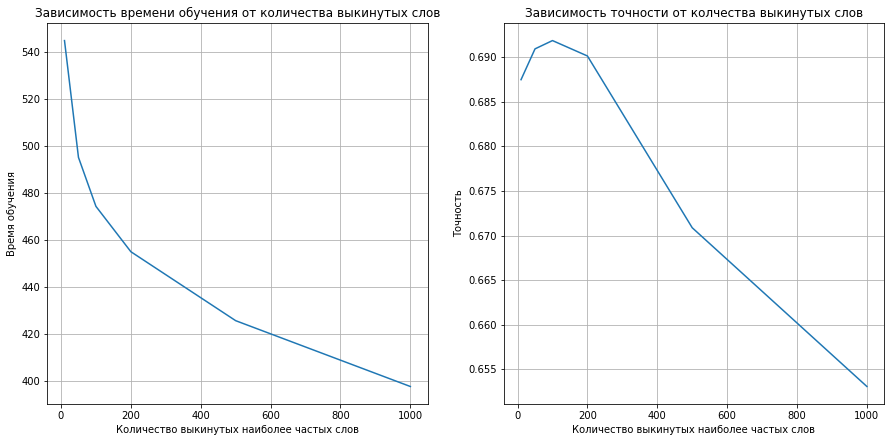

In [387]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(num_words, time_list)
ax1.set_title(u"Зависимость времени обучения от количества выкинутых слов")
ax1.set_xlabel(u"Количество выкинутых наиболее частых слов")
ax1.set_ylabel(u"Время обучения")
ax1.grid()
ax1.legend()

ax2.plot(num_words, accuracy_list)
ax2.set_title(u"Зависимость точности от колчества выкинутых слов")
ax2.set_xlabel(u"Количество выкинутых наиболее частых слов")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

plt.savefig("delete_words.pdf", format='pdf', bbox_inches='tight')

In [388]:
num_words = []
time_list = []
accuracy_list = []
amount = 0

cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)
for i in range(6):
    counts = np.asarray(X.sum(axis=0)).reshape(-1)
    amount += (counts == i).sum()
    num_words.append(amount)
    ind = np.argpartition(counts, amount)[amount::]
    X_new = X_idf[:, ind]
    new_test = test_data_idf[:, ind]
    X_new = (sparse.hstack((np.ones((X_new.shape[0], 1)), X_new))).tocsr()
    new_test = (sparse.hstack((np.ones((new_test.shape[0], 1)), new_test))).tocsr()
    start = time.time()
    cl_gd.fit(X_new, lem_data.target, trace=True)
    time_list.append(time.time() - start)
    accuracy_list.append((cl_gd.predict(new_test) == lem_data_test.target).sum() / lem_data_test.target.shape[0])

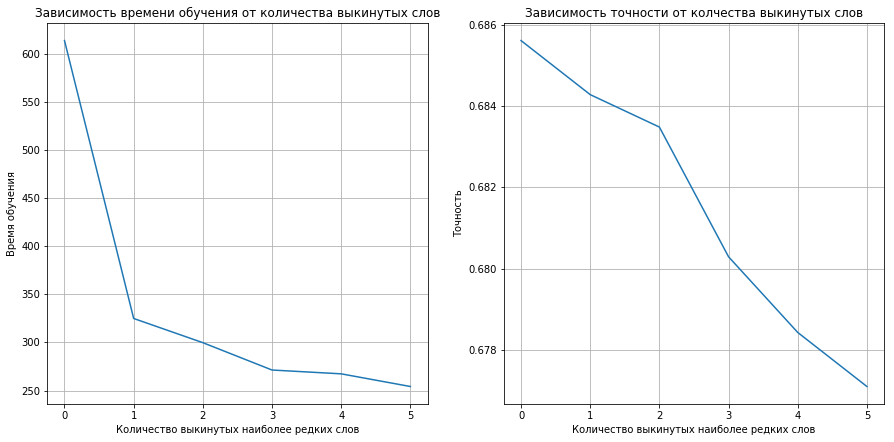

In [389]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(range(6), time_list)
ax1.set_title(u"Зависимость времени обучения от количества выкинутых слов")
ax1.set_xlabel(u"Количество выкинутых наиболее редких слов")
ax1.set_ylabel(u"Время обучения")
ax1.grid()
ax1.legend()

ax2.plot(range(6), accuracy_list)
ax2.set_title(u"Зависимость точности от колчества выкинутых слов")
ax2.set_xlabel(u"Количество выкинутых наиболее редких слов")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

plt.savefig("delete_words_rare.pdf", format='pdf', bbox_inches='tight')

In [309]:
counts = np.asarray(X.sum(axis=0)).reshape(-1)
ind = np.argpartition(counts, -100)[:-100:]
X_new = X_idf[:, ind]
new_test = test_data_idf[:, ind]
X_new = (sparse.hstack((np.ones((X_new.shape[0], 1)), X_new))).tocsr()
new_test = (sparse.hstack((np.ones((new_test.shape[0], 1)), new_test))).tocsr()

In [310]:
X_new.shape, new_test.shape

((11314, 93546), (7532, 93546))

In [311]:
cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

In [312]:
%time history_gd = cl_gd.fit(X_new, lem_data.target, trace=True)

CPU times: user 16min 14s, sys: 1min 1s, total: 17min 16s
Wall time: 9min 19s


In [313]:
preds = cl_gd.predict(new_test)
accuracy = (preds == lem_data_test.target).sum() / lem_data_test.target.shape[0]
print(accuracy)

0.691848114711


In [301]:
amount = (counts == 1).sum()
ind = np.argpartition(counts, amount)[amount::]
X_new = X_idf[:, ind]
ind2 = np.argpartition(counts[ind], -100)[:-100:]
X_new = X_new[:, ind2]
new_test = test_data_idf[:, ind]
new_test = new_test[:, ind2]
X_new = (sparse.hstack((np.ones((X_new.shape[0], 1)), X_new))).tocsr()
new_test = (sparse.hstack((np.ones((new_test.shape[0], 1)), new_test))).tocsr()

(11314, 39825)
(11314, 39725)


In [303]:
X_new.shape, new_test.shape

((11314, 39726), (7532, 39726))

In [304]:
cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

In [305]:
%time history_gd = cl_gd.fit(X_new, lem_data.target, trace=True)

CPU times: user 8min 55s, sys: 15.2 s, total: 9min 10s
Wall time: 4min 35s


In [306]:
preds = cl_gd.predict(new_test)
accuracy = (preds == lem_data_test.target).sum() / lem_data_test.target.shape[0]
print(accuracy)

0.690520446097


In [315]:
cl_tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
cl_tf_idf_vectorizer.fit(lem_data.data)
X = cl_tf_idf_vectorizer.transform(lem_data.data)
X = (sparse.hstack((np.ones((X.shape[0], 1)), X))).tocsr()
test_data = cl_tf_idf_vectorizer.transform(data_test.data)
test_data = (sparse.hstack((np.ones((test_data.shape[0], 1)), test_data))).tocsr()

In [317]:
print(X.shape, test_data.shape)

(11314, 93351) (7532, 93351)


In [318]:
cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

In [319]:
%time history_gd = cl_gd.fit(X, lem_data.target, trace=True)

CPU times: user 16min 44s, sys: 1min 5s, total: 17min 49s
Wall time: 9min 57s


In [320]:
preds = cl_gd.predict(test_data)
accuracy = (preds == lem_data_test.target).sum() / lem_data_test.target.shape[0]
print(accuracy)

0.666622411046


## Эксперимент 12

In [327]:
time_list = []
accuracy_list = []

cl_gd = GDClassifier(max_iter=2000, loss_function='multinomial_logistic',l2_coef=1e-6, tolerance=1e-6, step_alpha=100, step_beta=0.1, class_number=20)

for i in range(1, 3):
    cl_vectorizer = CountVectorizer(ngram_range=(1, i))
    X = cl_vectorizer.fit_transform(lem_data.data)
    test_data = cl_vectorizer.transform(lem_data_test.data)
    cl_tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1, i))
    X_idf = cl_tf_idf_vectorizer.fit_transform(lem_data.data)
    test_data_idf = cl_tf_idf_vectorizer.transform(lem_data_test.data)
    ind = np.argpartition(np.asarray(X.sum(axis=0)).reshape(-1), (-100) * (i ** 2))[:(-100) * (i ** 2):]
    X_new = X_idf[:, ind]
    new_test = test_data_idf[:, ind]
    X_new = (sparse.hstack((np.ones((X_new.shape[0], 1)), X_new))).tocsr()
    new_test = (sparse.hstack((np.ones((new_test.shape[0], 1)), new_test))).tocsr()
    start = time.time()
    cl_gd.fit(X_new, lem_data.target, trace=True)
    time_list.append(time.time() - start)
    accuracy_list.append((cl_gd.predict(new_test) == lem_data_test.target).sum() / lem_data_test.target.shape[0])

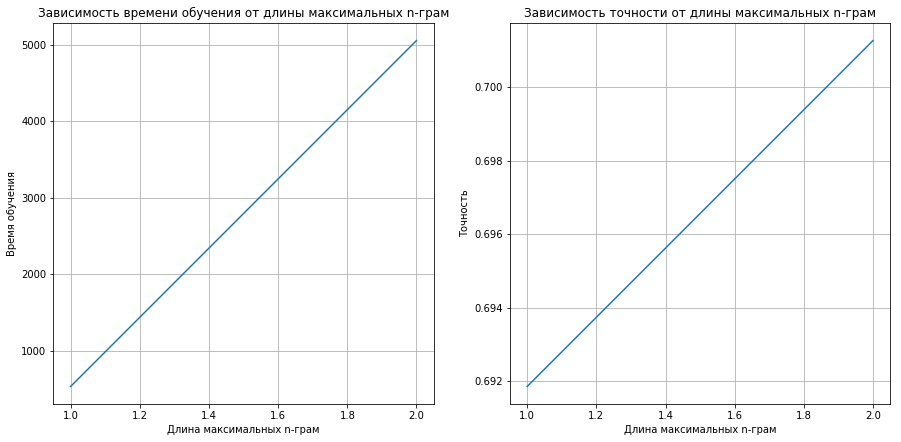

In [334]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(range(1, 3), time_list)
ax1.set_title(u"Зависимость времени обучения от длины максимальных n-грам")
ax1.set_xlabel(u"Длина максимальных n-грам")
ax1.set_ylabel(u"Время обучения")
ax1.grid()
ax1.legend()

ax2.plot(range(1, 3), accuracy_list)
ax2.set_title(u"Зависимость точности от длины максимальных n-грам")
ax2.set_xlabel(u"Длина максимальных n-грам")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

plt.savefig("ngram.pdf", format='pdf', bbox_inches='tight')

In [382]:
print(time_list, accuracy_list)

[532.3992819786072, 5053.026782035828] [0.69184811471056828, 0.70127456186935744]
